# Análisis estadístico inferencial

Este cuaderno calcula comparaciones entre grupos para ROSC, Supervivencia 7 días y CPC favorable (1-2), y genera forest plots de odds ratios con IC95%.

Grupos a comparar (mutuamente excluyentes):
- Sin RCP previa
- RCP por legos SIN RCP transtelefónica
- RCP CON RCP transtelefónica
- RCP por sanitarios y/o bomberos (incluye policía si actúan como primeros respondientes uniformados)

Salidas del cuaderno:
- Tablas de contingencia y pruebas χ² (conmutación a Fisher cuando proceda)
- OR crudas con IC95% vs referencia y comparaciones clave
- Figuras: forest plots por outcome en `final_noteboooks/outputs_inferencia/`
- Esquema del paper al final del cuaderno

In [1]:
# Configuración e importación de librerías
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Diseño visual (según instrucciones)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.serif'] = ['Times New Roman']
sns.set(style="whitegrid")

# Descubrir raíz del workspace (para rutas relativas robustas)
def find_root():
    candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for base in candidates:
        if (base / 'data' / '3.cleaned_data').exists() and (base / 'final_noteboooks').exists():
            return base
    return Path.cwd()

ROOT = find_root()
DATA_PATH = ROOT / 'data' / '3.cleaned_data' / 'datos_limpios.xlsx - Sheet 1.csv'
OUT_DIR = ROOT / 'final_noteboooks' / 'outputs_inferencia'
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Workspace root: {ROOT}")
print(f"Usando datos: {DATA_PATH}")
print(f"Guardando salidas en: {OUT_DIR}")

Workspace root: /Users/miguelrosa/Desktop/RCP Transtelefonica
Usando datos: /Users/miguelrosa/Desktop/RCP Transtelefonica/data/3.cleaned_data/datos_limpios.xlsx - Sheet 1.csv
Guardando salidas en: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia


In [2]:
# Carga y preprocesamiento de datos

df = pd.read_csv(DATA_PATH)

# Normalizar nombres de columnas (por si hay espacios o codificación)
df.columns = [c.strip() for c in df.columns]

# Variables esperadas
# - RCP_TRANSTELEFONICA (0/1)
# - RCP_TESTIGOS: categorías como 'lego','sanitario','policia','bombero','falso'
# - ROSC (0/1)
# - Supervivencia_7dias (0/1)
# - CPC (1-5, CPC 1-2 favorable)

# Crear variable de CPC favorable
def cpc_favorable(x):
    try:
        v = int(x)
        return 1 if v in (1, 2) else 0
    except Exception:
        return np.nan

if 'CPC_favorable' not in df.columns:
    df['CPC_favorable'] = df['CPC'].apply(cpc_favorable)

# Mapear 5 grupos mutuamente excluyentes
# Prioridad de asignación:
# 1) Sin RCP previa -> RCP_TESTIGOS == 'falso' y RCP_TRANSTELEFONICA == 0
# 2) RCP CON RCP transtelefónica -> RCP_TRANSTELEFONICA == 1
# 3) RCP legos SIN RCP transtelefónica -> RCP_TESTIGOS == 'lego' y RCP_TRANSTELEFONICA == 0
# 4) RCP por sanitarios -> RCP_TESTIGOS == 'sanitario' y RCP_TRANSTELEFONICA == 0
# 5) RCP por policía/bomberos -> RCP_TESTIGOS in {'policia','bombero'} y RCP_TRANSTELEFONICA == 0

def asignar_grupo(row):
    telf = int(row.get('RCP_TRANSTELEFONICA', 0)) if pd.notna(row.get('RCP_TRANSTELEFONICA', np.nan)) else 0
    testigo = str(row.get('RCP_TESTIGOS', '')).strip().lower()
    if testigo == 'falso' and telf == 0:
        return 'Sin RCP'
    if telf == 1:
        return 'RCP telefónica'
    if testigo == 'lego' and telf == 0:
        return 'RCP legos sin telefónica'
    if testigo == 'sanitario' and telf == 0:
        return 'RCP sanitarios'
    if testigo in {'policia', 'bombero'} and telf == 0:
        return 'RCP policía/bomberos'
    return np.nan

if 'grupo_rcp' not in df.columns:
    df['grupo_rcp'] = df.apply(asignar_grupo, axis=1)
else:
    # Recalcular si ya existía para asegurar 5 grupos
    df['grupo_rcp'] = df.apply(asignar_grupo, axis=1)

# Outcomes a evaluar
outcomes = {
    'ROSC': 'ROSC',
    'Supervivencia': 'Supervivencia_7dias',
    'CPC_favorable': 'CPC_favorable'
}

# Limpiar tipos
for col in outcomes.values():
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Subset válido por outcome
valid_counts = {k: df[[v, 'grupo_rcp']].dropna().shape[0] for k, v in outcomes.items()}
print('Casos válidos por outcome:', valid_counts)

# Distribución de grupos
print('Distribución por grupo:')
print(df['grupo_rcp'].value_counts(dropna=False))

Casos válidos por outcome: {'ROSC': 497, 'Supervivencia': 499, 'CPC_favorable': 500}
Distribución por grupo:
grupo_rcp
Sin RCP                     166
RCP telefónica              113
RCP sanitarios               86
RCP legos sin telefónica     77
RCP policía/bomberos         58
Name: count, dtype: int64


In [5]:
# Utilidades para pruebas y OR con IC95%
from typing import Tuple, Dict

def two_by_two_or(a: int, b: int, c: int, d: int) -> Tuple[float, float, float]:
    """
    Calcula OR y IC95% (Woolf logit) para tabla 2x2:
        [[a, b],
         [c, d]]
    Devuelve (OR, LCL95, UCL95). Usa corrección Haldane-Anscombe si hay ceros.
    """
    aa, bb, cc, dd = a, b, c, d
    # Corrección si hay celdas 0
    if min(aa, bb, cc, dd) == 0:
        aa += 0.5; bb += 0.5; cc += 0.5; dd += 0.5
    or_val = (aa * dd) / (bb * cc)
    se = np.sqrt(1/aa + 1/bb + 1/cc + 1/dd)
    log_or = np.log(or_val)
    lcl = np.exp(log_or - 1.96*se)
    ucl = np.exp(log_or + 1.96*se)
    return float(or_val), float(lcl), float(ucl)


def chisq_or_fisher(table: np.ndarray) -> Dict[str, float]:
    """
    Ejecuta Chi-cuadrado (o Fisher si hay expectativas <5) sobre 2xk o 2x2.
    Retorna dict con chi2, p_value, test_used.
    """
    # Si es 2x2 considerar Fisher exacto si hay recuentos bajos
    if table.shape == (2, 2):
        # Comprobar frecuencias esperadas
        chi2, p, dof, exp = stats.chi2_contingency(table, correction=False)
        if (exp < 5).any():
            _, p_fisher = stats.fisher_exact(table)
            return {"test": "Fisher", "chi2": float(chi2), "p_value": float(p_fisher)}
        else:
            return {"test": "Chi2", "chi2": float(chi2), "p_value": float(p)}
    else:
        chi2, p, dof, exp = stats.chi2_contingency(table, correction=False)
        return {"test": "Chi2", "chi2": float(chi2), "p_value": float(p)}


def build_contingency(df_in: pd.DataFrame, group_col: str, outcome_col: str) -> pd.DataFrame:
    """Devuelve tabla de contingencia (grupos x outcome_binario)"""
    sub = df_in[[group_col, outcome_col]].dropna()
    sub[outcome_col] = sub[outcome_col].astype(int)
    ct = pd.crosstab(sub[group_col], sub[outcome_col]).rename(columns={0: 'No', 1: 'Sí'})
    # Asegurar columnas 'No' y 'Sí' aunque alguna falte
    for col in ['No', 'Sí']:
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[['No', 'Sí']]
    return ct


def or_vs_reference(ct: pd.DataFrame, ref_label: str) -> pd.DataFrame:
    """
    Calcula OR con IC95% para cada grupo vs ref_label.
    ct: index=grupos, columns=['No','Sí']
    """
    rows = []
    if ref_label not in ct.index:
        raise ValueError(f"Referencia '{ref_label}' no está en la tabla: {list(ct.index)}")
    ref_no, ref_si = int(ct.loc[ref_label, 'No']), int(ct.loc[ref_label, 'Sí'])
    for grp in ct.index:
        if grp == ref_label:
            rows.append({"grupo": grp, "OR": 1.0, "LCL95": 1.0, "UCL95": 1.0})
            continue
        no, si = int(ct.loc[grp, 'No']), int(ct.loc[grp, 'Sí'])
        or_val, lcl, ucl = two_by_two_or(si, no, ref_si, ref_no)  # outcome=Sí como evento
        rows.append({"grupo": grp, "OR": or_val, "LCL95": lcl, "UCL95": ucl})
    res = pd.DataFrame(rows).set_index('grupo').loc[ct.index]
    return res


def save_json(obj, path: Path):
    with open(path, 'w') as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

In [10]:
# Función para generar forest plot

def forest_plot(or_df: pd.DataFrame, title: str, filename: str):
    labels = or_df.index.tolist()
    ors = or_df['OR'].values
    lcl = or_df['LCL95'].values
    ucl = or_df['UCL95'].values
    y = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(8, 0.6*len(labels) + 1))
    ax.errorbar(ors, y, xerr=[ors - lcl, ucl - ors], fmt='o', color='black', capsize=4)
    ax.axvline(1.0, color='red', linestyle='--', alpha=0.7)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Odds Ratio (IC 95%)')
    ax.set_title(title)
    plt.tight_layout()
    out_path = OUT_DIR / filename
    plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    print(f"Guardado: {out_path}")


=== Outcome: ROSC (ROSC) ===
ROSC                      No  Sí
grupo_rcp                       
Sin RCP                   76  89
RCP legos sin telefónica  24  53
RCP telefónica            44  67
RCP sanitarios            24  62
RCP policía/bomberos      29  29
Test: {'test': 'Chi2', 'chi2': 12.702267852456611, 'p_value': 0.012826020124394027}
                                OR     LCL95     UCL95
grupo_rcp                                             
Sin RCP                   1.000000  1.000000  1.000000
RCP legos sin telefónica  1.885768  1.065178  3.338521
RCP telefónica            1.300306  0.798022  2.118735
RCP sanitarios            2.205993  1.257682  3.869342
RCP policía/bomberos      0.853933  0.469176  1.554215


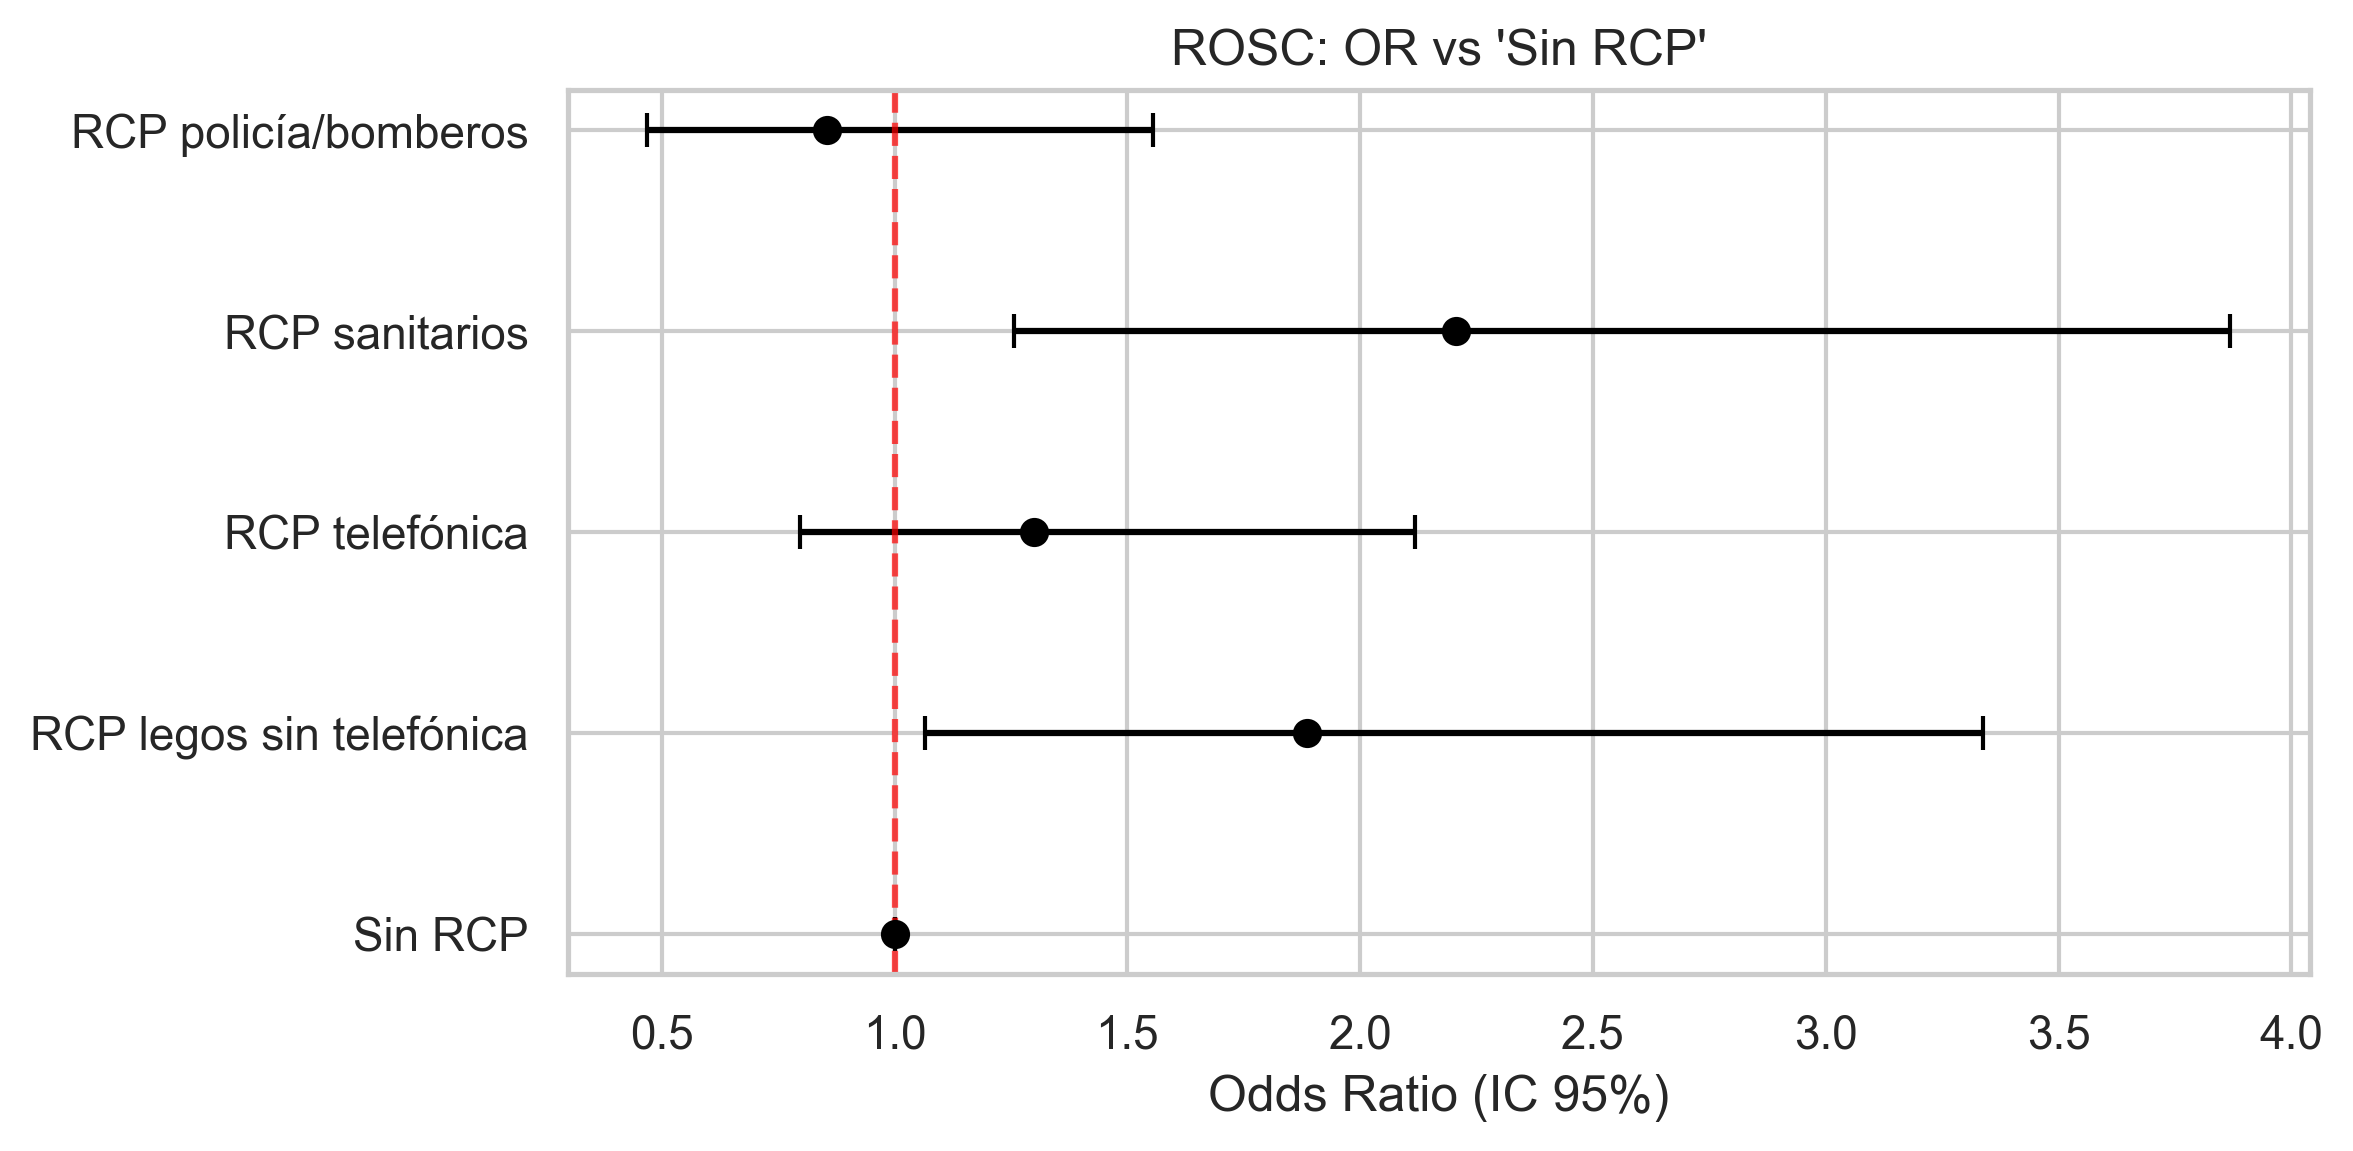

Guardado: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia/forest_ROSC_vs_sinrcp.png

=== Outcome: Supervivencia (Supervivencia_7dias) ===
Supervivencia_7dias        No  Sí
grupo_rcp                        
Sin RCP                   137  28
RCP legos sin telefónica   55  22
RCP telefónica             80  33
RCP sanitarios             49  37
RCP policía/bomberos       49   9
Test: {'test': 'Chi2', 'chi2': 24.21072541652212, 'p_value': 7.246975940464695e-05}
                                OR     LCL95     UCL95
grupo_rcp                                             
Sin RCP                   1.000000  1.000000  1.000000
RCP legos sin telefónica  1.957143  1.031901  3.711992
RCP telefónica            2.018304  1.136650  3.583819
RCP sanitarios            3.694606  2.049119  6.661456
RCP policía/bomberos      0.898688  0.396273  2.038089


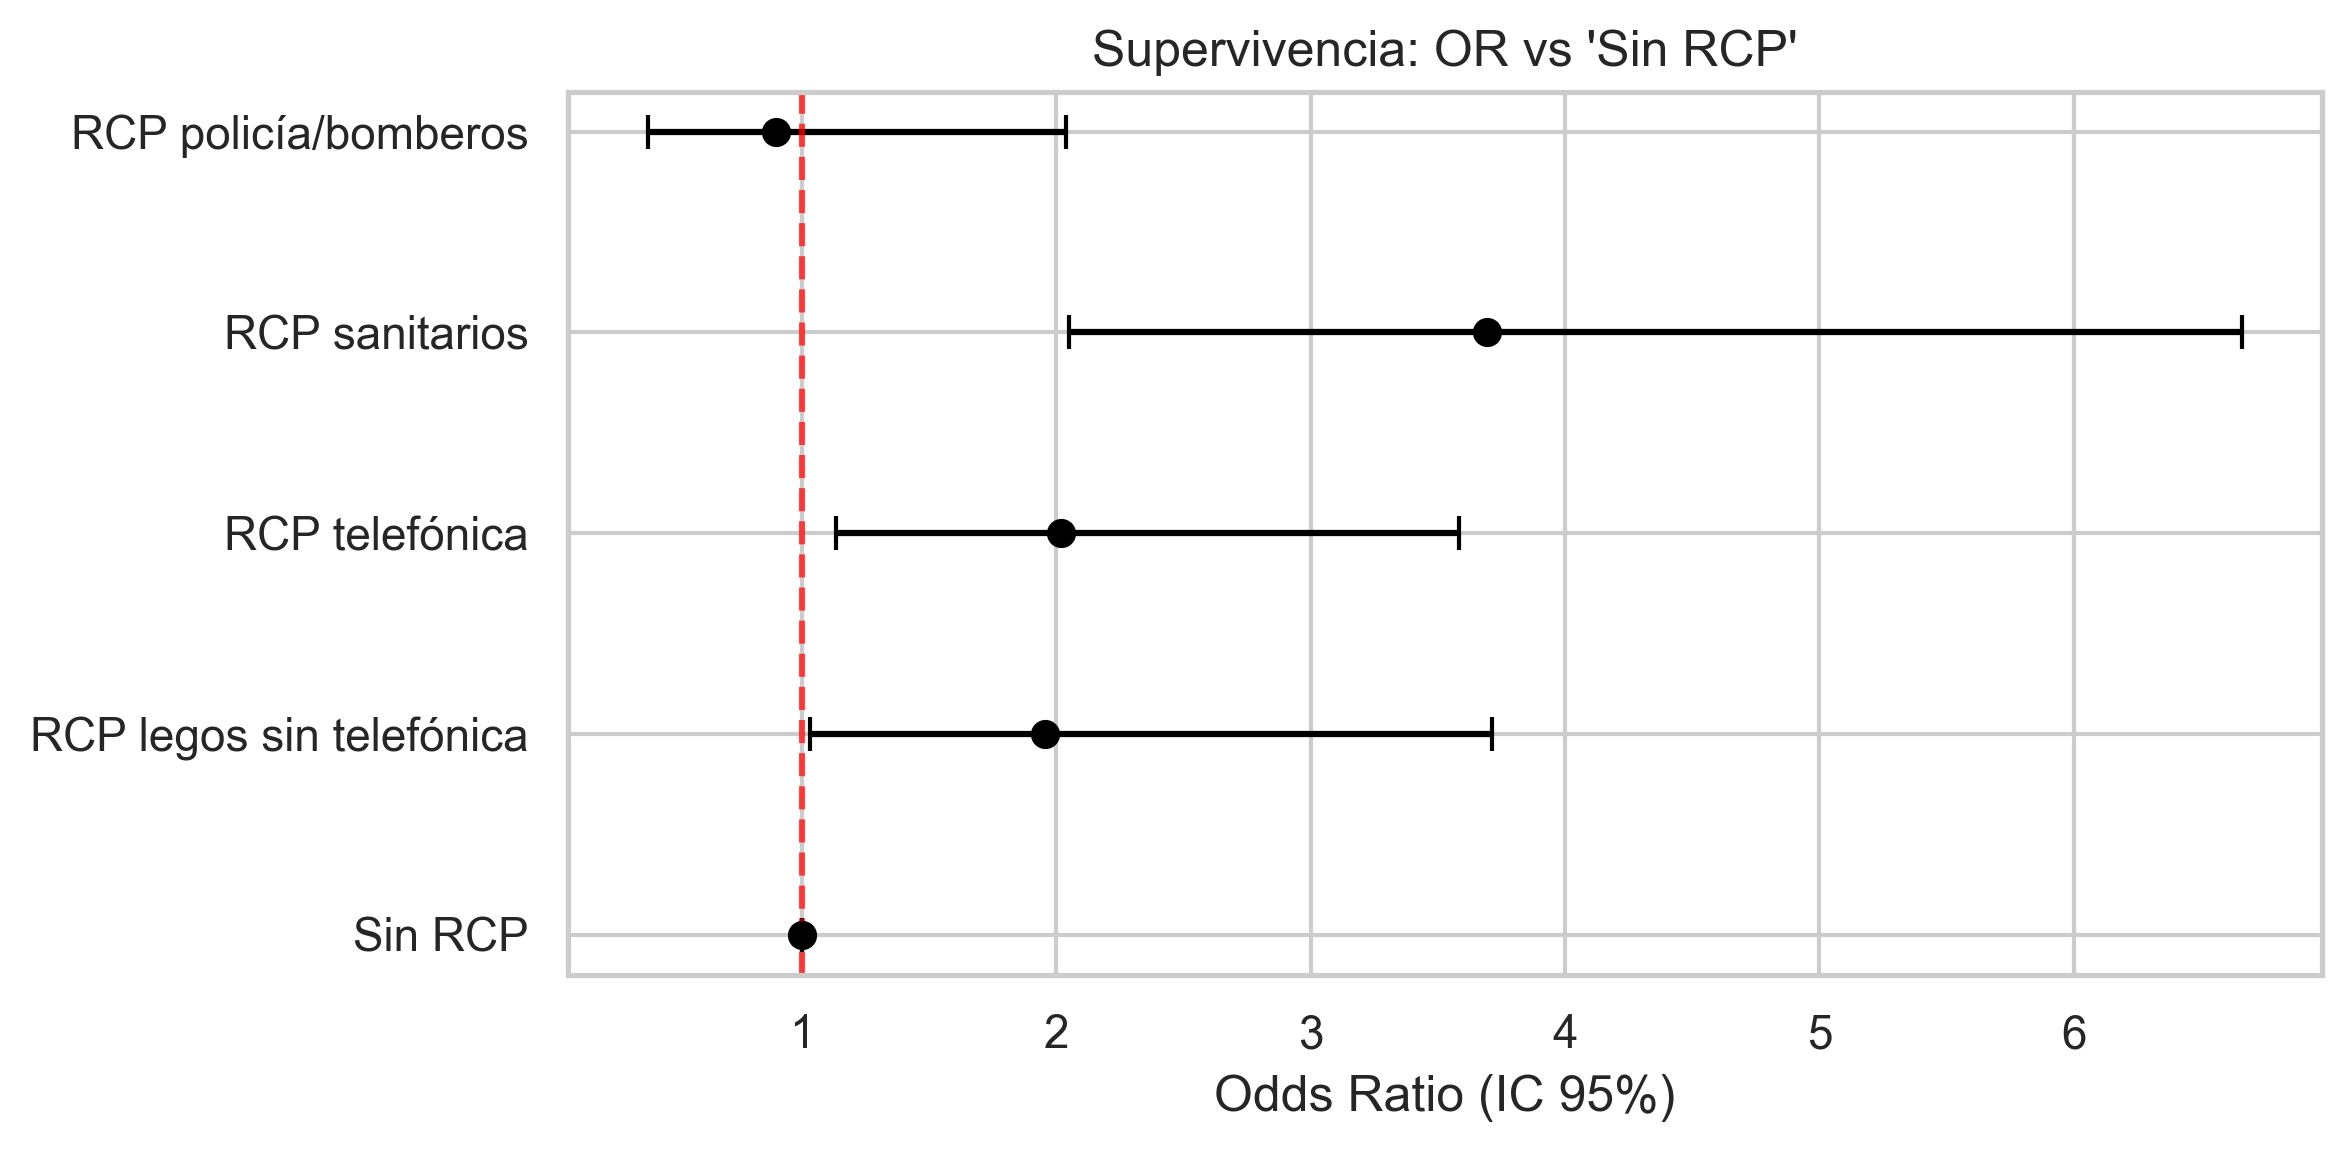

Guardado: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia/forest_Supervivencia_7dias_vs_sinrcp.png

=== Outcome: CPC_favorable (CPC_favorable) ===
CPC_favorable              No  Sí
grupo_rcp                        
Sin RCP                   144  22
RCP legos sin telefónica   57  20
RCP telefónica             87  26
RCP sanitarios             51  35
RCP policía/bomberos       50   8
Test: {'test': 'Chi2', 'chi2': 27.78204134380748, 'p_value': 1.380800198201668e-05}
                                OR     LCL95     UCL95
grupo_rcp                                             
Sin RCP                   1.000000  1.000000  1.000000
RCP legos sin telefónica  2.296651  1.164917  4.527881
RCP telefónica            1.956113  1.044876  3.662041
RCP sanitarios            4.491979  2.412582  8.363602
RCP policía/bomberos      1.047273  0.438397  2.501798


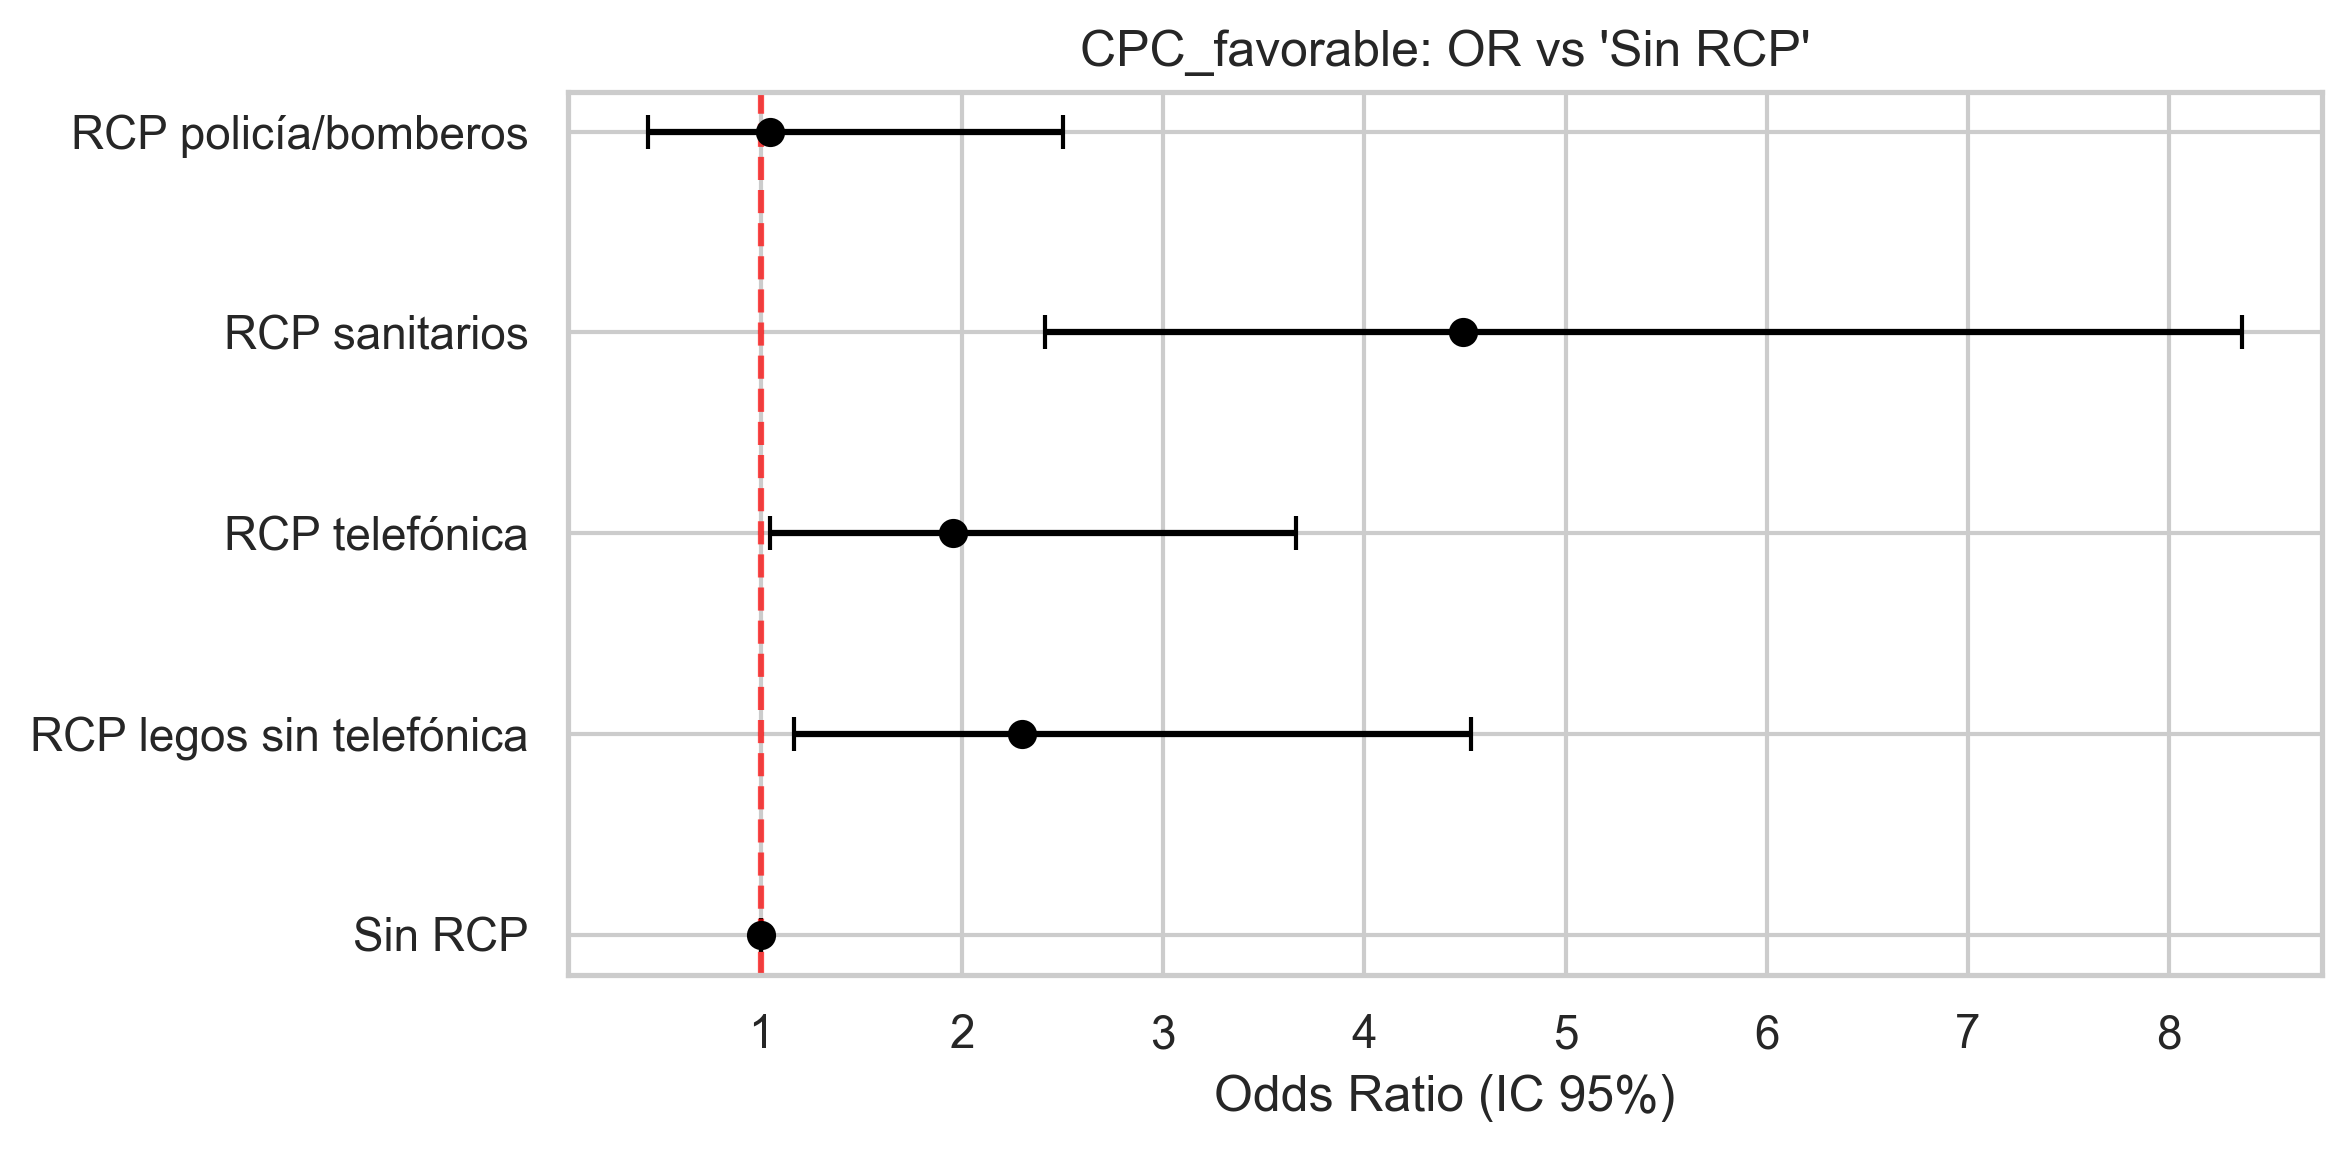

Guardado: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia/forest_CPC_favorable_vs_sinrcp.png
Resultados guardados en JSON.


In [12]:
# Análisis principal: tablas, pruebas y forest por outcome

resultados = {}
order = ['Sin RCP', 'RCP legos sin telefónica', 'RCP telefónica', 'RCP sanitarios', 'RCP policía/bomberos']

for nombre, col in outcomes.items():
    print(f"\n=== Outcome: {nombre} ({col}) ===")
    sub = df[[col, 'grupo_rcp']].dropna()
    sub = sub[sub['grupo_rcp'].isin(order)].copy()
    ct = build_contingency(sub, 'grupo_rcp', col)
    # Reordenar (puede que falte algún grupo si n=0)
    ct = ct.reindex([g for g in order if g in ct.index])
    print(ct)

    # χ² global para 2×k
    chi2_res = chisq_or_fisher(ct.values)
    print('Test:', chi2_res)

    # OR vs referencia (Sin RCP)
    if 'Sin RCP' in ct.index:
        or_df = or_vs_reference(ct, ref_label='Sin RCP')
        print(or_df)
        # Forest plot
        fname = f"forest_{col}_vs_sinrcp.png"
        forest_plot(or_df, title=f"{nombre}: OR vs 'Sin RCP'", filename=fname)
    else:
        print("No hay grupo de referencia 'Sin RCP' en los datos; se omite forest plot.")
        or_df = pd.DataFrame()

    # Guardar JSON con resultados por outcome
    resultados[nombre] = {
        'contingencia': ct.to_dict(),
        'test': chi2_res,
        'or_vs_ref': (or_df.reset_index().to_dict(orient='records') if not or_df.empty else [])
    }

# Persistir resultados
save_json(resultados, OUT_DIR / 'resultados_inferencia_5_statistical_analysis.json')
print('Resultados guardados en JSON.')

## Esquema del paper (IMRaD)

- Título provisional: Impacto de la RCP transtelefónica en ROSC, supervivencia y estado neurológico en PCR extrahospitalario
- Resumen (≤350 palabras): Contexto, objetivo, métodos, resultados clave (OR con IC95%), conclusiones
- Palabras clave (MeSH): Cardiopulmonary Resuscitation; Telephone; Out-of-Hospital Cardiac Arrest; Survival; Neurologic Outcomes; Emergency Medical Services

### Introducción
- Epidemiología de la PCR extrahospitalaria y relevancia de RCP por testigos
- RCP transtelefónica (T-CPR): evidencia previa y lagunas
- Objetivo primario: comparar ROSC, supervivencia y CPC favorable entre grupos
- Hipótesis: T-CPR mejora resultados vs. Sin RCP y vs. RCP por legos sin guía; efecto relativo frente a profesionales

### Métodos
- Diseño: observacional retrospectivo
- Población: todos los casos en la base de datos (criterios de inclusión/exclusión detallados en limpieza)
- Exposición: cuatro grupos mutuamente excluyentes
  1) Sin RCP
  2) RCP legos sin telefónica
  3) RCP telefónica
  4) RCP sanitarios/bomberos
- Outcomes: ROSC, Supervivencia 7 días, CPC favorable (1-2)
- Análisis estadístico:
  - Tablas de contingencia (2×k) y χ² global; Fisher en 2×2 según necesidad
  - OR crudas con IC95% vs. referencia (Sin RCP); corrección de Haldane si hay ceros
  - Estratificaciones a realizar en cuadernos dedicados: edad (<65/≥65), tiempo de llegada (≤/> mediana)
  - Corrección por comparaciones múltiples: Bonferroni/FDR (pendiente si se reporta multiparámetro)

### Resultados
- Tabla 1: características basales (véase cuaderno 2)
- Resultados principales por outcome: tablas de proporciones, χ², forest plots de OR
- Resultados clave destacados con n, proporciones y p-valores

### Discusión
- Interpretación de magnitud y dirección del efecto de T-CPR
- Comparación con la literatura
- Implicaciones clínicas y de política sanitaria
- Limitaciones: confusión residual, misclasificación de exposición, tamaño muestral por subgrupos
- Líneas futuras: modelos ajustados, análisis de sensibilidad, estratificación adicional

### Material suplementario
- JSON de resultados generado por este cuaderno
- Figuras en `final_noteboooks/outputs_inferencia/`

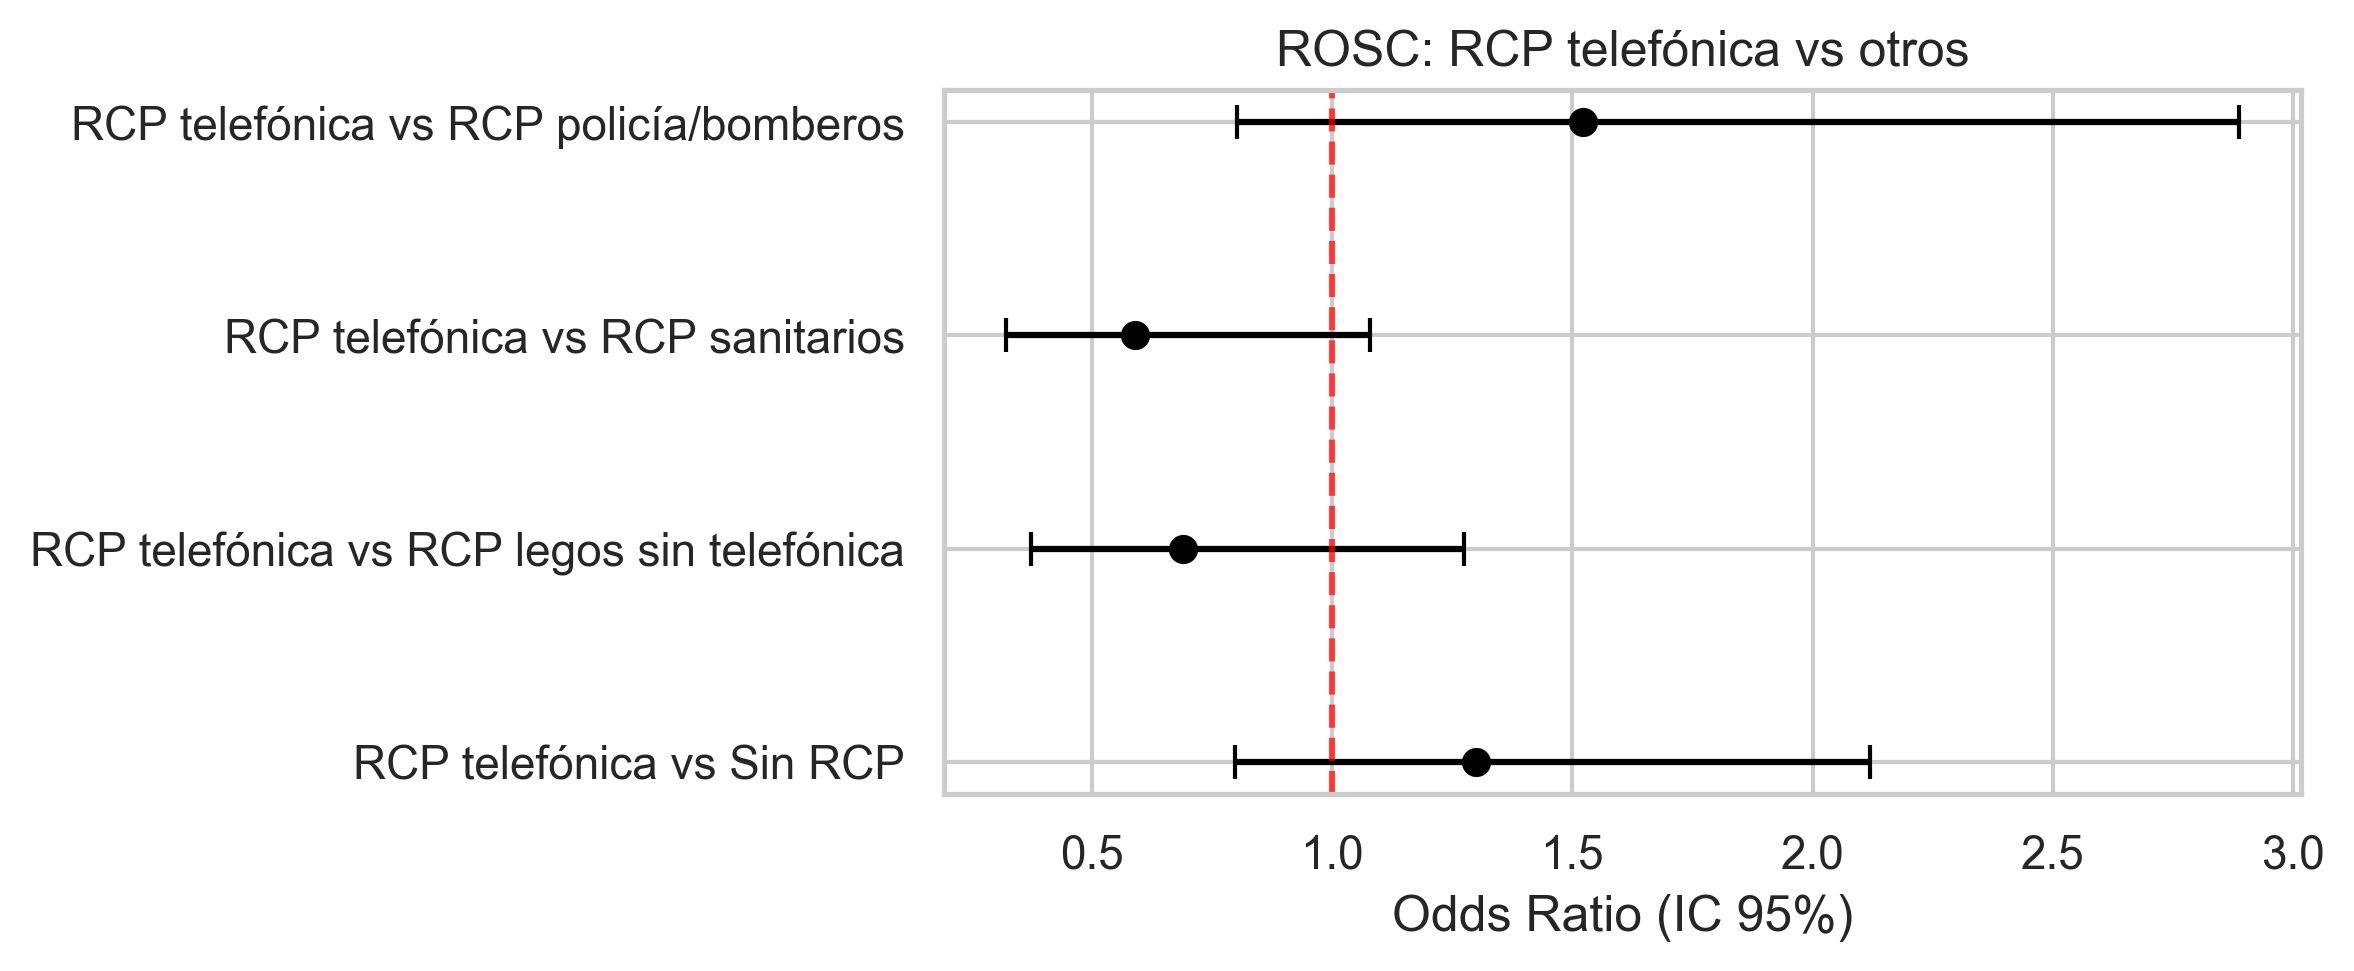

Guardado: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia/forest_ROSC_ref_telefonica.png


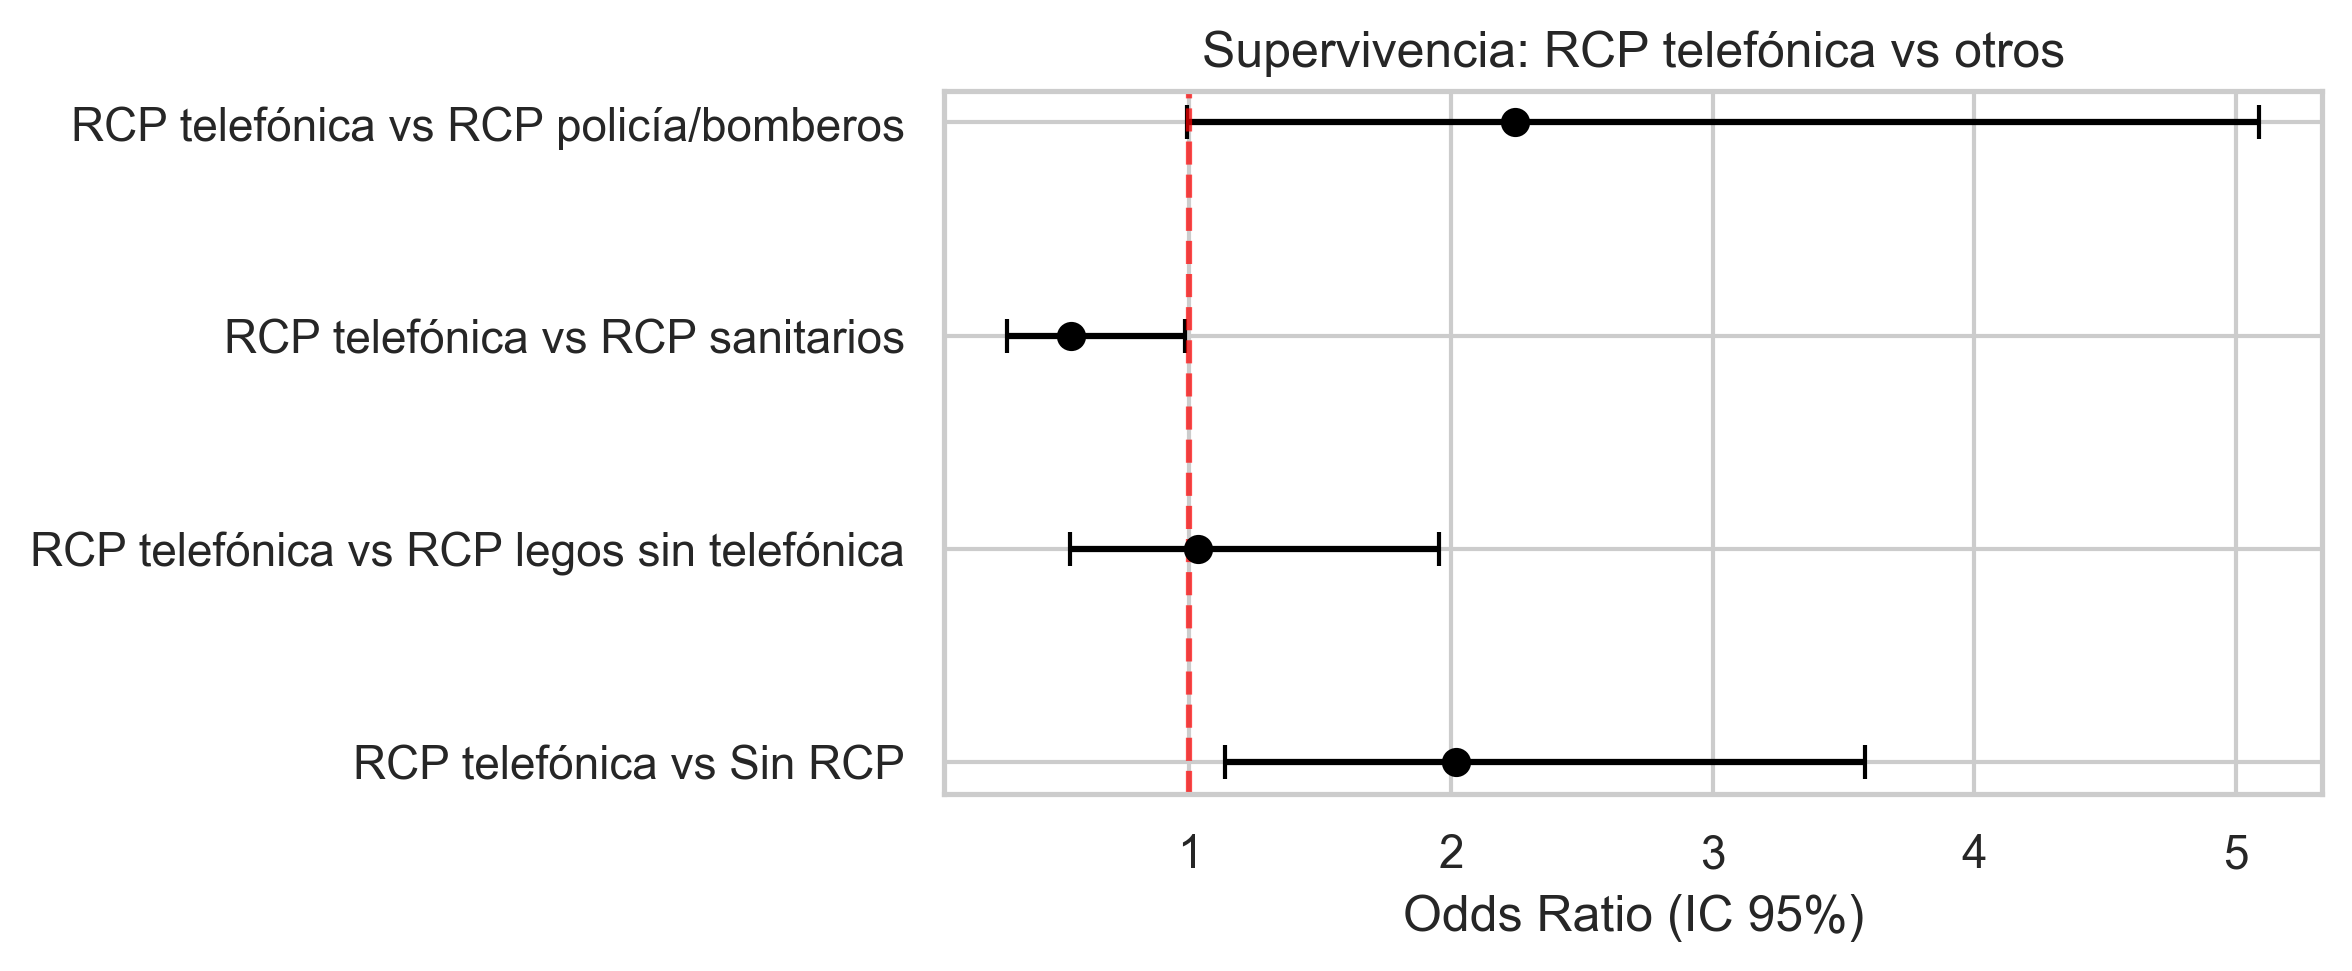

Guardado: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia/forest_Supervivencia_7dias_ref_telefonica.png


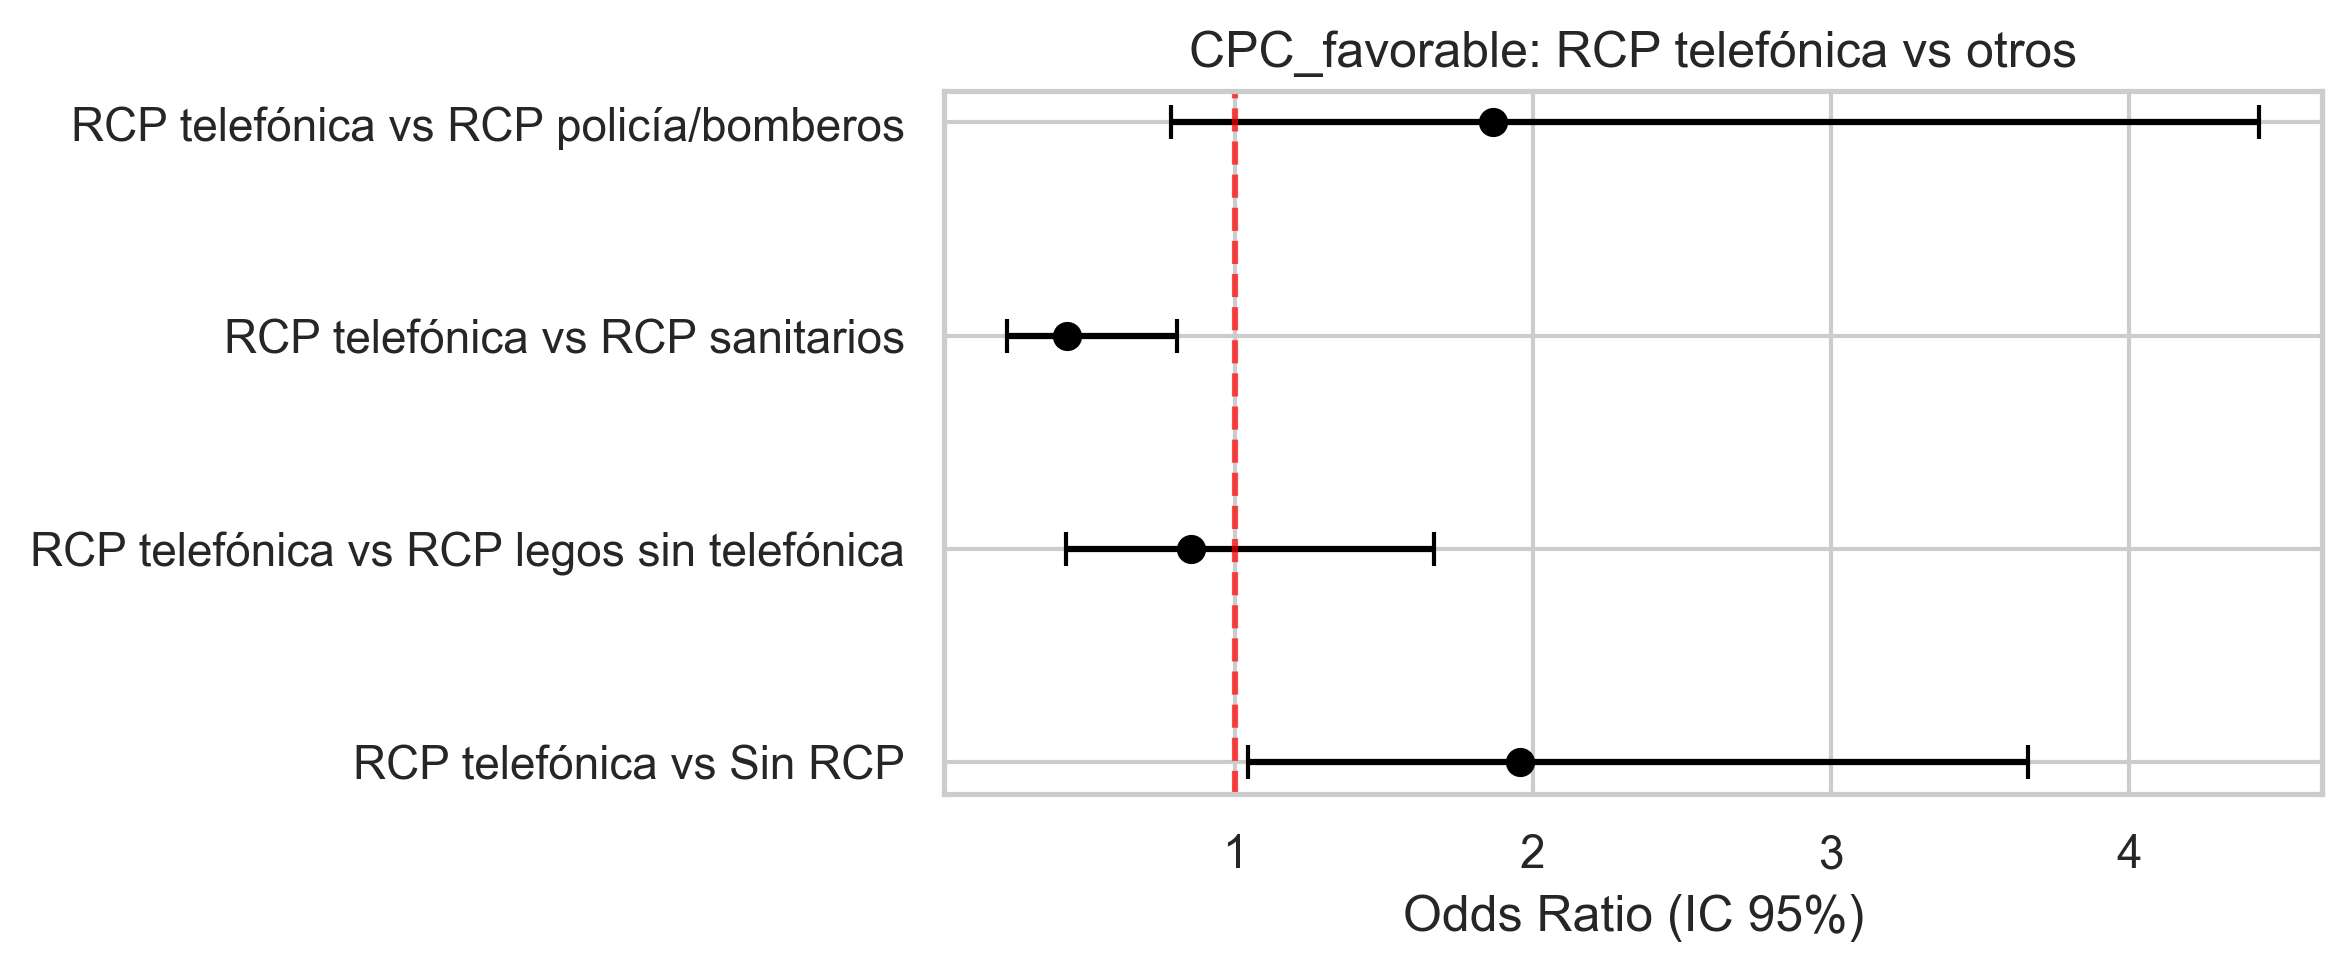

Guardado: /Users/miguelrosa/Desktop/RCP Transtelefonica/final_noteboooks/outputs_inferencia/forest_CPC_favorable_ref_telefonica.png
Comparaciones pareadas guardadas en JSON.


In [13]:
# Comparaciones pareadas con referencia 'RCP telefónica'

pairwise_results = {}
ref_label = 'RCP telefónica'

for nombre, col in outcomes.items():
    sub = df[[col, 'grupo_rcp']].dropna()
    grupos_presentes = [g for g in order if g in sub['grupo_rcp'].unique() and g != ref_label]
    rows = []
    for g in grupos_presentes:
        sub2 = sub[sub['grupo_rcp'].isin([ref_label, g])].copy()
        ct = build_contingency(sub2, 'grupo_rcp', col)
        # Reordenar: ref primero
        ct = ct.reindex([ref_label, g])
        # OR g vs ref (ref en denominador); si queremos OR de ref vs g, invertimos
        # Aquí reportamos OR (ref vs g) centrado en interpretar si T-CPR mejora (OR>1 a favor de ref)
        a = int(ct.loc[ref_label, 'Sí']); b = int(ct.loc[ref_label, 'No'])
        c = int(ct.loc[g, 'Sí']); d = int(ct.loc[g, 'No'])
        or_val, lcl, ucl = two_by_two_or(a, b, c, d)
        # Fisher exacto de 2x2
        _, p_fisher = stats.fisher_exact(np.array([[a, b], [c, d]]))
        rows.append({
            'comparado_con': g,
            'OR_ref_vs_g': or_val,
            'LCL95': lcl,
            'UCL95': ucl,
            'p_fisher': float(p_fisher),
            'n_ref': int(a+b),
            'n_g': int(c+d)
        })
    df_rows = pd.DataFrame(rows).set_index('comparado_con') if rows else pd.DataFrame()
    pairwise_results[nombre] = df_rows.reset_index().to_dict(orient='records') if not df_rows.empty else []

    # Forest plot con referencia explícita (ref en título)
    if not df_rows.empty:
        # Construir or_df con índice como etiquetas 'RCP telefónica vs X'
        or_plot = df_rows.copy()
        or_plot.index = [f"{ref_label} vs {ix}" for ix in or_plot.index]
        or_plot = or_plot[['OR_ref_vs_g','LCL95','UCL95']]
        or_plot.columns = ['OR','LCL95','UCL95']
        forest_plot(or_plot, title=f"{nombre}: {ref_label} vs otros", filename=f"forest_{col}_ref_telefonica.png")

# Guardar JSON de comparaciones pareadas
save_json(pairwise_results, OUT_DIR / 'pairwise_ref_telefonica_5_statistical_analysis.json')
print('Comparaciones pareadas guardadas en JSON.')

In [6]:
# Matriz de comparativa: RCP telefónica vs sin telefónica (excluyendo 'Sin RCP')
# Definición: 'sin telefónica' = RCP legos sin telefónica + RCP sanitarios + RCP policía/bomberos

comp = df.copy()
comp = comp[comp['grupo_rcp'].isin(['RCP telefónica', 'RCP legos sin telefónica', 'RCP sanitarios', 'RCP policía/bomberos'])]
comp['telf_vs_no'] = comp['grupo_rcp'].apply(lambda x: 'RCP telefónica' if x == 'RCP telefónica' else 'Sin telefónica')

matriz = {}
rows_csv = []
for nombre, col in outcomes.items():
    sub = comp[[col, 'telf_vs_no']].dropna().copy()
    sub[col] = sub[col].astype(int)
    ct = pd.crosstab(sub['telf_vs_no'], sub[col]).rename(columns={0:'No',1:'Sí'})
    # OR (evento=Sí) de T-CPR vs No-T-CPR
    a = int(ct.loc['RCP telefónica','Sí']) if 'RCP telefónica' in ct.index and 'Sí' in ct.columns else 0
    b = int(ct.loc['RCP telefónica','No']) if 'RCP telefónica' in ct.index and 'No' in ct.columns else 0
    c = int(ct.loc['Sin telefónica','Sí']) if 'Sin telefónica' in ct.index and 'Sí' in ct.columns else 0
    d = int(ct.loc['Sin telefónica','No']) if 'Sin telefónica' in ct.index and 'No' in ct.columns else 0
    or_val, lcl, ucl = two_by_two_or(a,b,c,d)
    _, p_fisher = stats.fisher_exact(np.array([[a,b],[c,d]]))
    matriz[nombre] = {
        'tabla': ct.to_dict(),
        'OR_TCPR_vs_NoT': or_val,
        'LCL95': lcl,
        'UCL95': ucl,
        'p_fisher': float(p_fisher),
        'n_TCPR': int(a+b),
        'n_NoT': int(c+d)
    }
    rows_csv.append({
        'Outcome': nombre,
        'OR_TCPR_vs_NoT': or_val,
        'LCL95': lcl,
        'UCL95': ucl,
        'p_fisher': float(p_fisher),
        'n_TCPR': int(a+b),
        'n_NoT': int(c+d)
    })

# Guardar JSON y CSV
save_json(matriz, OUT_DIR / 'matriz_tcp_vs_notcp.json')
pd.DataFrame(rows_csv).to_csv(OUT_DIR / 'matriz_tcp_vs_notcp.csv', index=False)
print('Matriz T-CPR vs no T-CPR guardada (JSON y CSV).')
matriz

Matriz T-CPR vs no T-CPR guardada.


{'ROSC': {'tabla': {'No': {'RCP telefónica': 44, 'Sin telefónica': 77},
   'Sí': {'RCP telefónica': 67, 'Sin telefónica': 144}},
  'OR_TCPR_vs_NoT': 0.8142361111111112,
  'LCL95': 0.5087289208934359,
  'UCL95': 1.3032096611944362,
  'p_fisher': 0.40001255650565226,
  'n_TCPR': 111,
  'n_NoT': 221},
 'Supervivencia': {'tabla': {'No': {'RCP telefónica': 80,
    'Sin telefónica': 153},
   'Sí': {'RCP telefónica': 33, 'Sin telefónica': 68}},
  'OR_TCPR_vs_NoT': 0.928125,
  'LCL95': 0.5651818488118384,
  'UCL95': 1.5241395622239533,
  'p_fisher': 0.8022281080316773,
  'n_TCPR': 113,
  'n_NoT': 221},
 'CPC_favorable': {'tabla': {'No': {'RCP telefónica': 87,
    'Sin telefónica': 158},
   'Sí': {'RCP telefónica': 26, 'Sin telefónica': 63}},
  'OR_TCPR_vs_NoT': 0.749498266739646,
  'LCL95': 0.44270532407053637,
  'UCL95': 1.2688974387762957,
  'p_fisher': 0.29847237888560174,
  'n_TCPR': 113,
  'n_NoT': 221}}

In [7]:
# Estratificaciones: edad (<=65 vs >65), tiempo de llegada (<= mediana vs > mediana), ritmo inicial (desfibrilable vs no)

# Preparar variables estrato
estratos = {}

# Edad
if 'EDAD' in df.columns:
    df['edad_bin'] = pd.to_numeric(df['EDAD'], errors='coerce')
    mediana_edad = df['edad_bin'].median()
    df['edad_cat'] = np.where(df['edad_bin'] <= 65, '<=65', '>65')
    estratos['edad_cat'] = ['<=65','>65']

# Tiempo de llegada
if 'Tiempo_llegada' in df.columns:
    df['tiempo_llegada_min'] = pd.to_numeric(df['Tiempo_llegada'], errors='coerce')
    mediana_llegada = df['tiempo_llegada_min'].median()
    df['llegada_cat'] = np.where(df['tiempo_llegada_min'] <= mediana_llegada, f'≤{int(mediana_llegada)}s', f'>{int(mediana_llegada)}s')
    estratos['llegada_cat'] = [f'≤{int(mediana_llegada)}s', f'>{int(mediana_llegada)}s']

# Ritmo inicial (desfibrilable)
if 'Desfibrilable_inicial' in df.columns:
    df['ritmo_desf'] = pd.to_numeric(df['Desfibrilable_inicial'], errors='coerce')
    df['ritmo_cat'] = df['ritmo_desf'].map({1:'Desfibrilable', 0:'No desfibrilable'})
    estratos['ritmo_cat'] = ['Desfibrilable', 'No desfibrilable']

# Comparativa T-CPR vs No T-CPR en cada estrato, por outcome
estrato_resultados = {}
for estrato_col, levels in estratos.items():
    estrato_resultados[estrato_col] = {}
    for lvl in levels:
        sub = df[(df[estrato_col] == lvl) & df['grupo_rcp'].isin(['RCP telefónica', 'RCP legos sin telefónica', 'RCP sanitarios', 'RCP policía/bomberos'])].copy()
        if sub.empty:
            continue
        sub['telf_vs_no'] = sub['grupo_rcp'].apply(lambda x: 'RCP telefónica' if x == 'RCP telefónica' else 'Sin telefónica')
        estrato_resultados[estrato_col][lvl] = {}
        for nombre, col in outcomes.items():
            tmp = sub[[col, 'telf_vs_no']].dropna().copy()
            if tmp.empty:
                continue
            tmp[col] = tmp[col].astype(int)
            ct = pd.crosstab(tmp['telf_vs_no'], tmp[col]).rename(columns={0:'No',1:'Sí'})
            a = int(ct.loc['RCP telefónica','Sí']) if 'RCP telefónica' in ct.index and 'Sí' in ct.columns else 0
            b = int(ct.loc['RCP telefónica','No']) if 'RCP telefónica' in ct.index and 'No' in ct.columns else 0
            c = int(ct.loc['Sin telefónica','Sí']) if 'Sin telefónica' in ct.index and 'Sí' in ct.columns else 0
            d = int(ct.loc['Sin telefónica','No']) if 'Sin telefónica' in ct.index and 'No' in ct.columns else 0
            or_val, lcl, ucl = two_by_two_or(a,b,c,d)
            _, p_fisher = stats.fisher_exact(np.array([[a,b],[c,d]]))
            estrato_resultados[estrato_col][lvl][nombre] = {
                'tabla': ct.to_dict(),
                'OR_TCPR_vs_NoT': or_val,
                'LCL95': lcl,
                'UCL95': ucl,
                'p_fisher': float(p_fisher),
                'n_TCPR': int(a+b),
                'n_NoT': int(c+d)
            }

save_json(estrato_resultados, OUT_DIR / 'estratos_tcp_vs_notcp.json')
print('Resultados de estratificaciones guardados.')

Resultados de estratificaciones guardados.


In [8]:
# Regresión logística multivariable: outcome ~ T-CPR + edad + sexo + tiempo llegada + ritmo desfibrilable
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Preparar dataset para regresiones
reg = df.copy()
# Variable exposición: TCPR (1) vs No-TCPR en casos con algún tipo de RCP (excluye 'Sin RCP')
reg = reg[reg['grupo_rcp'].isin(['RCP telefónica', 'RCP legos sin telefónica', 'RCP sanitarios', 'RCP policía/bomberos'])].copy()
reg['TCPR'] = (reg['grupo_rcp'] == 'RCP telefónica').astype(int)

# Covariables
reg['edad'] = pd.to_numeric(reg['EDAD'], errors='coerce')
reg['sexo_m'] = reg['SEXO'].map({'Masculino':1, 'Femenino':0})
reg['t_llegada'] = pd.to_numeric(reg['Tiempo_llegada'], errors='coerce')
reg['ritmo'] = pd.to_numeric(reg['Desfibrilable_inicial'], errors='coerce')

# Eliminar filas con NA en variables necesarias
covs = ['TCPR','edad','sexo_m','t_llegada','ritmo']
model_data = {}


def fit_logit(outcome_col: str):
    data = reg[covs + [outcome_col]].dropna().copy()
    # En algunos outcomes 'Supervivencia_7dias' ya es 0/1; CPC_favorable también
    data[outcome_col] = pd.to_numeric(data[outcome_col], errors='coerce')
    data = data.dropna()
    # Escalado simple de tiempo llegada (minutos) si está en segundos
    # Mantendremos escala original (segundos) para interpretarlo per 100s
    data['t_llegada_100'] = data['t_llegada'] / 100.0
    formula = f"{outcome_col} ~ TCPR + edad + sexo_m + t_llegada_100 + ritmo"
    model = smf.logit(formula=formula, data=data).fit(disp=False, maxiter=200)
    params = model.params
    conf = model.conf_int()
    or_adj = params.apply(np.exp)
    lcl = conf[0].apply(np.exp)
    ucl = conf[1].apply(np.exp)
    pvals = model.pvalues
    res = pd.DataFrame({
        'term': or_adj.index,
        'aOR': or_adj.values,
        'LCL95': lcl.values,
        'UCL95': ucl.values,
        'p_value': pvals.values
    })
    return res, int(data.shape[0])

ajustados = {}
for nombre, col in outcomes.items():
    res, n = fit_logit(col)
    ajustados[nombre] = {
        'n': n,
        'resultados': res.to_dict(orient='records')
    }

save_json(ajustados, OUT_DIR / 'logistica_ajustada_tcp_vs_notcp.json')
ajustados

ImportError: cannot import name '_lazywhere' from 'scipy._lib._util' (/Users/miguelrosa/Desktop/RCP Transtelefonica/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py)

In [9]:
# Logística multivariable con scikit-learn + bootstrap para IC95%
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Dataset: mismos filtros que antes
reg = df.copy()
reg = reg[reg['grupo_rcp'].isin(['RCP telefónica', 'RCP legos sin telefónica', 'RCP sanitarios', 'RCP policía/bomberos'])].copy()
reg['TCPR'] = (reg['grupo_rcp'] == 'RCP telefónica').astype(int)
reg['edad'] = pd.to_numeric(reg['EDAD'], errors='coerce')
reg['sexo_m'] = reg['SEXO'].map({'Masculino':1, 'Femenino':0})
reg['t_llegada'] = pd.to_numeric(reg['Tiempo_llegada'], errors='coerce')
reg['ritmo'] = pd.to_numeric(reg['Desfibrilable_inicial'], errors='coerce')

covs = ['TCPR','edad','sexo_m','t_llegada','ritmo']


def fit_lr_bootstrap(outcome_col, B=1000, C=1.0):
    data = reg[covs + [outcome_col]].dropna().copy()
    y = data[outcome_col].astype(int).values
    X = data[covs].values
    # Modelo base
    base = LogisticRegression(max_iter=1000, solver='lbfgs', C=C)
    base.fit(X, y)
    coef_base = base.coef_[0]
    # Bootstrap percentiles
    coefs = []
    for _ in range(B):
        Xb, yb = resample(X, y, replace=True, n_samples=len(y))
        m = LogisticRegression(max_iter=1000, solver='lbfgs', C=C)
        try:
            m.fit(Xb, yb)
            coefs.append(m.coef_[0])
        except Exception:
            continue
    coefs = np.array(coefs)
    # OR e IC95% por percentil
    terms = covs
    results = []
    for j, term in enumerate(terms):
        or_hat = np.exp(coef_base[j])
        if coefs.size > 0:
            lcl = np.exp(np.percentile(coefs[:, j], 2.5))
            ucl = np.exp(np.percentile(coefs[:, j], 97.5))
        else:
            lcl = np.nan
            ucl = np.nan
        results.append({'term': term, 'aOR': float(or_hat), 'LCL95': float(lcl), 'UCL95': float(ucl)})
    return results, len(y)

ajustados_boot = {}
for nombre, col in outcomes.items():
    res, n = fit_lr_bootstrap(col, B=1000)
    ajustados_boot[nombre] = {'n': n, 'resultados': res}

save_json(ajustados_boot, OUT_DIR / 'logistica_ajustada_bootstrap_tcp_vs_notcp.json')
pd.DataFrame([{'Outcome': k, **{r['term']: r['aOR'] for r in v['resultados']}, 'n': v['n']} for k, v in ajustados_boot.items()]).to_csv(OUT_DIR / 'logistica_ajustada_bootstrap_resumen.csv', index=False)
ajustados_boot

{'ROSC': {'n': 303,
  'resultados': [{'term': 'TCPR',
    'aOR': 0.7591921706275173,
    'LCL95': 0.43081234190218504,
    'UCL95': 1.3358454262751362},
   {'term': 'edad',
    'aOR': 0.9663769821538961,
    'LCL95': 0.9454891111682682,
    'UCL95': 0.9821693731110305},
   {'term': 'sexo_m',
    'aOR': 0.8862751418756551,
    'LCL95': 0.4867090580248518,
    'UCL95': 1.5948994824630292},
   {'term': 't_llegada',
    'aOR': 0.9996923000781,
    'LCL95': 0.9988472283665517,
    'UCL95': 1.0009307437299066},
   {'term': 'ritmo',
    'aOR': 7.289238112045003,
    'LCL95': 4.5805667241904855,
    'UCL95': 12.995588393618258}]},
 'Supervivencia': {'n': 305,
  'resultados': [{'term': 'TCPR',
    'aOR': 1.0480027979511406,
    'LCL95': 0.63335019185782,
    'UCL95': 1.7852486996086285},
   {'term': 'edad',
    'aOR': 0.9759588374543305,
    'LCL95': 0.9557576006076557,
    'UCL95': 0.9917041235105171},
   {'term': 'sexo_m',
    'aOR': 1.1973653329823797,
    'LCL95': 0.6670264560504018,
    'U

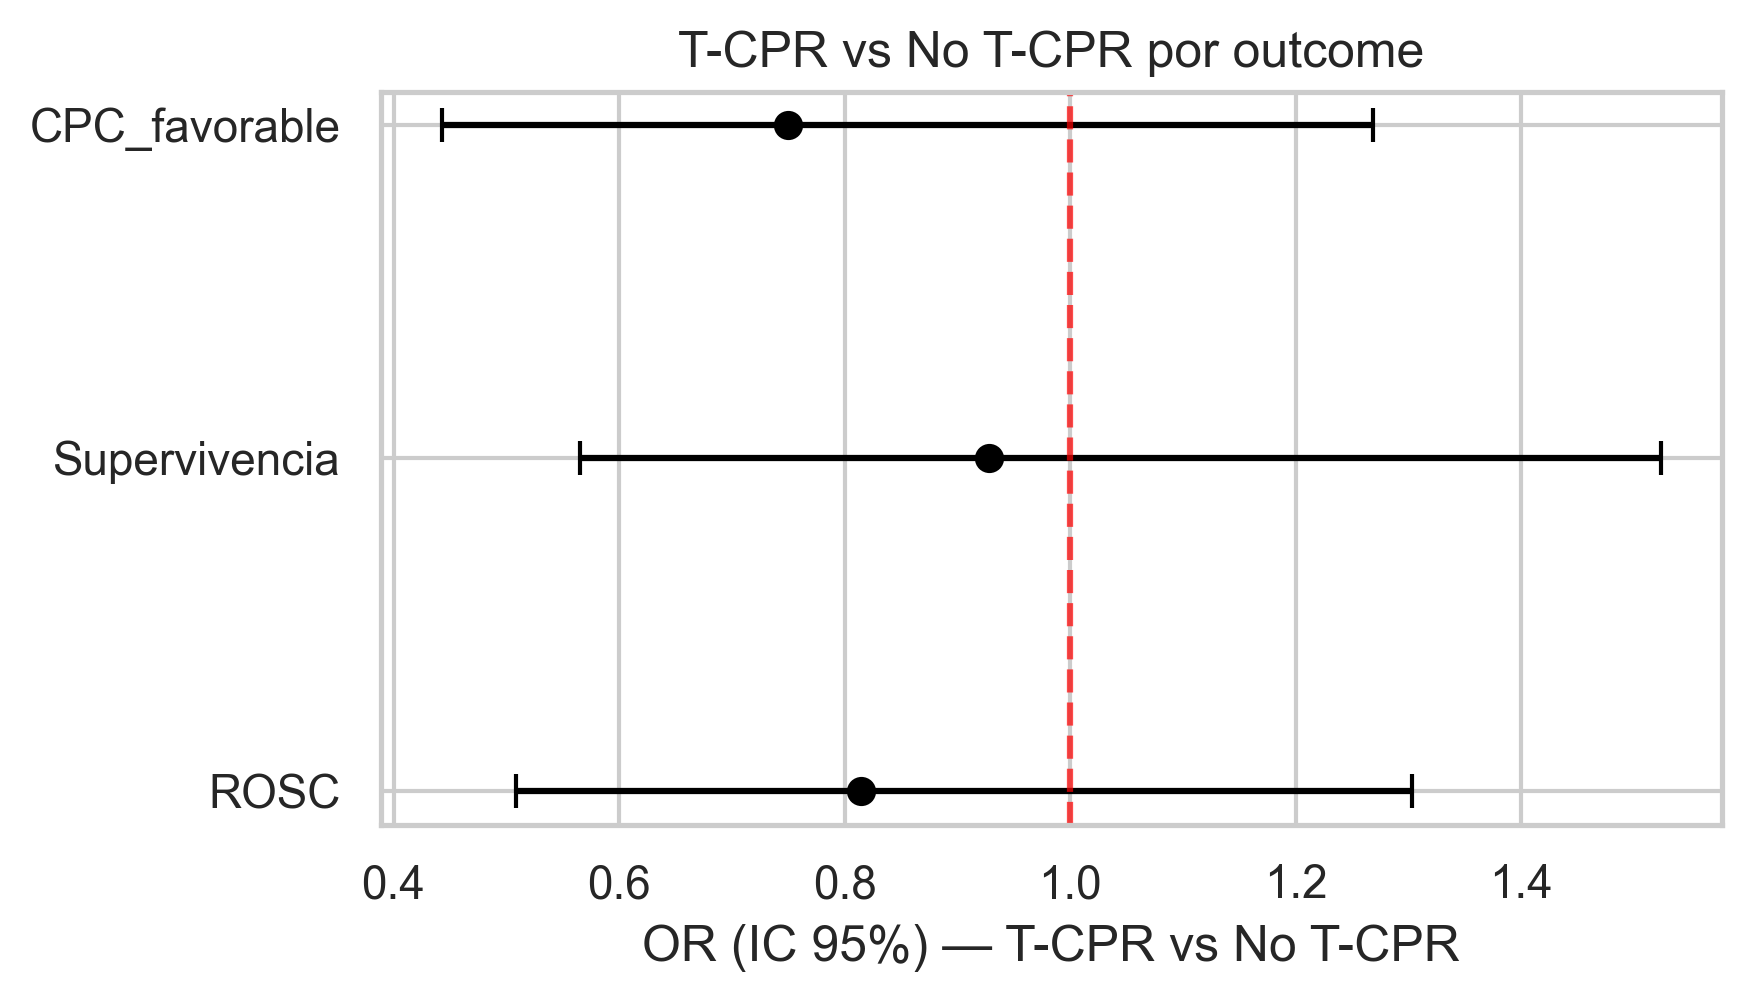

In [11]:
# Gráfica 1: Forest plot OR T-CPR vs No T-CPR por outcome (sin guardar JSON)

# Asegurar que tenemos la matriz en memoria; si no, recalcular rápido
try:
    _ = matriz
except NameError:
    comp = df.copy()
    comp = comp[comp['grupo_rcp'].isin(['RCP telefónica', 'RCP legos sin telefónica', 'RCP sanitarios', 'RCP policía/bomberos'])]
    comp['telf_vs_no'] = comp['grupo_rcp'].apply(lambda x: 'RCP telefónica' if x == 'RCP telefónica' else 'Sin telefónica')
    matriz = {}
    for nombre, col in outcomes.items():
        sub = comp[[col, 'telf_vs_no']].dropna().copy()
        sub[col] = sub[col].astype(int)
        ct = pd.crosstab(sub['telf_vs_no'], sub[col]).rename(columns={0:'No',1:'Sí'})
        a = int(ct.loc['RCP telefónica','Sí']) if 'RCP telefónica' in ct.index and 'Sí' in ct.columns else 0
        b = int(ct.loc['RCP telefónica','No']) if 'RCP telefónica' in ct.index and 'No' in ct.columns else 0
        c = int(ct.loc['Sin telefónica','Sí']) if 'Sin telefónica' in ct.index and 'Sí' in ct.columns else 0
        d = int(ct.loc['Sin telefónica','No']) if 'Sin telefónica' in ct.index and 'No' in ct.columns else 0
        or_val, lcl, ucl = two_by_two_or(a,b,c,d)
        # usar clave homogénea
        matriz[nombre] = {'OR_TCPR_vs_NoT': or_val, 'LCL95': lcl, 'UCL95': ucl}

# Construir DataFrame para la figura (acepta ambas variantes de clave)
m_rows = []
for k, v in matriz.items():
    if 'OR' in v:
        m_row = {'Outcome': k, 'OR': v['OR'], 'LCL95': v['LCL95'], 'UCL95': v['UCL95']}
    else:
        m_row = {'Outcome': k, 'OR': v.get('OR_TCPR_vs_NoT', np.nan), 'LCL95': v['LCL95'], 'UCL95': v['UCL95']}
    m_rows.append(m_row)

m_df = pd.DataFrame(m_rows).set_index('Outcome').loc[['ROSC','Supervivencia','CPC_favorable']]

# Forest
labels = m_df.index.tolist()
ors = m_df['OR'].values
lcl = m_df['LCL95'].values
ucl = m_df['UCL95'].values
y = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.errorbar(ors, y, xerr=[ors-lcl, ucl-ors], fmt='o', color='black', capsize=4)
ax.axvline(1.0, color='red', linestyle='--', alpha=0.7)
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('OR (IC 95%) — T-CPR vs No T-CPR')
ax.set_title('T-CPR vs No T-CPR por outcome')
plt.tight_layout()
plt.savefig(OUT_DIR / 'forest_TCPR_vs_NoTCPR_outcomes.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

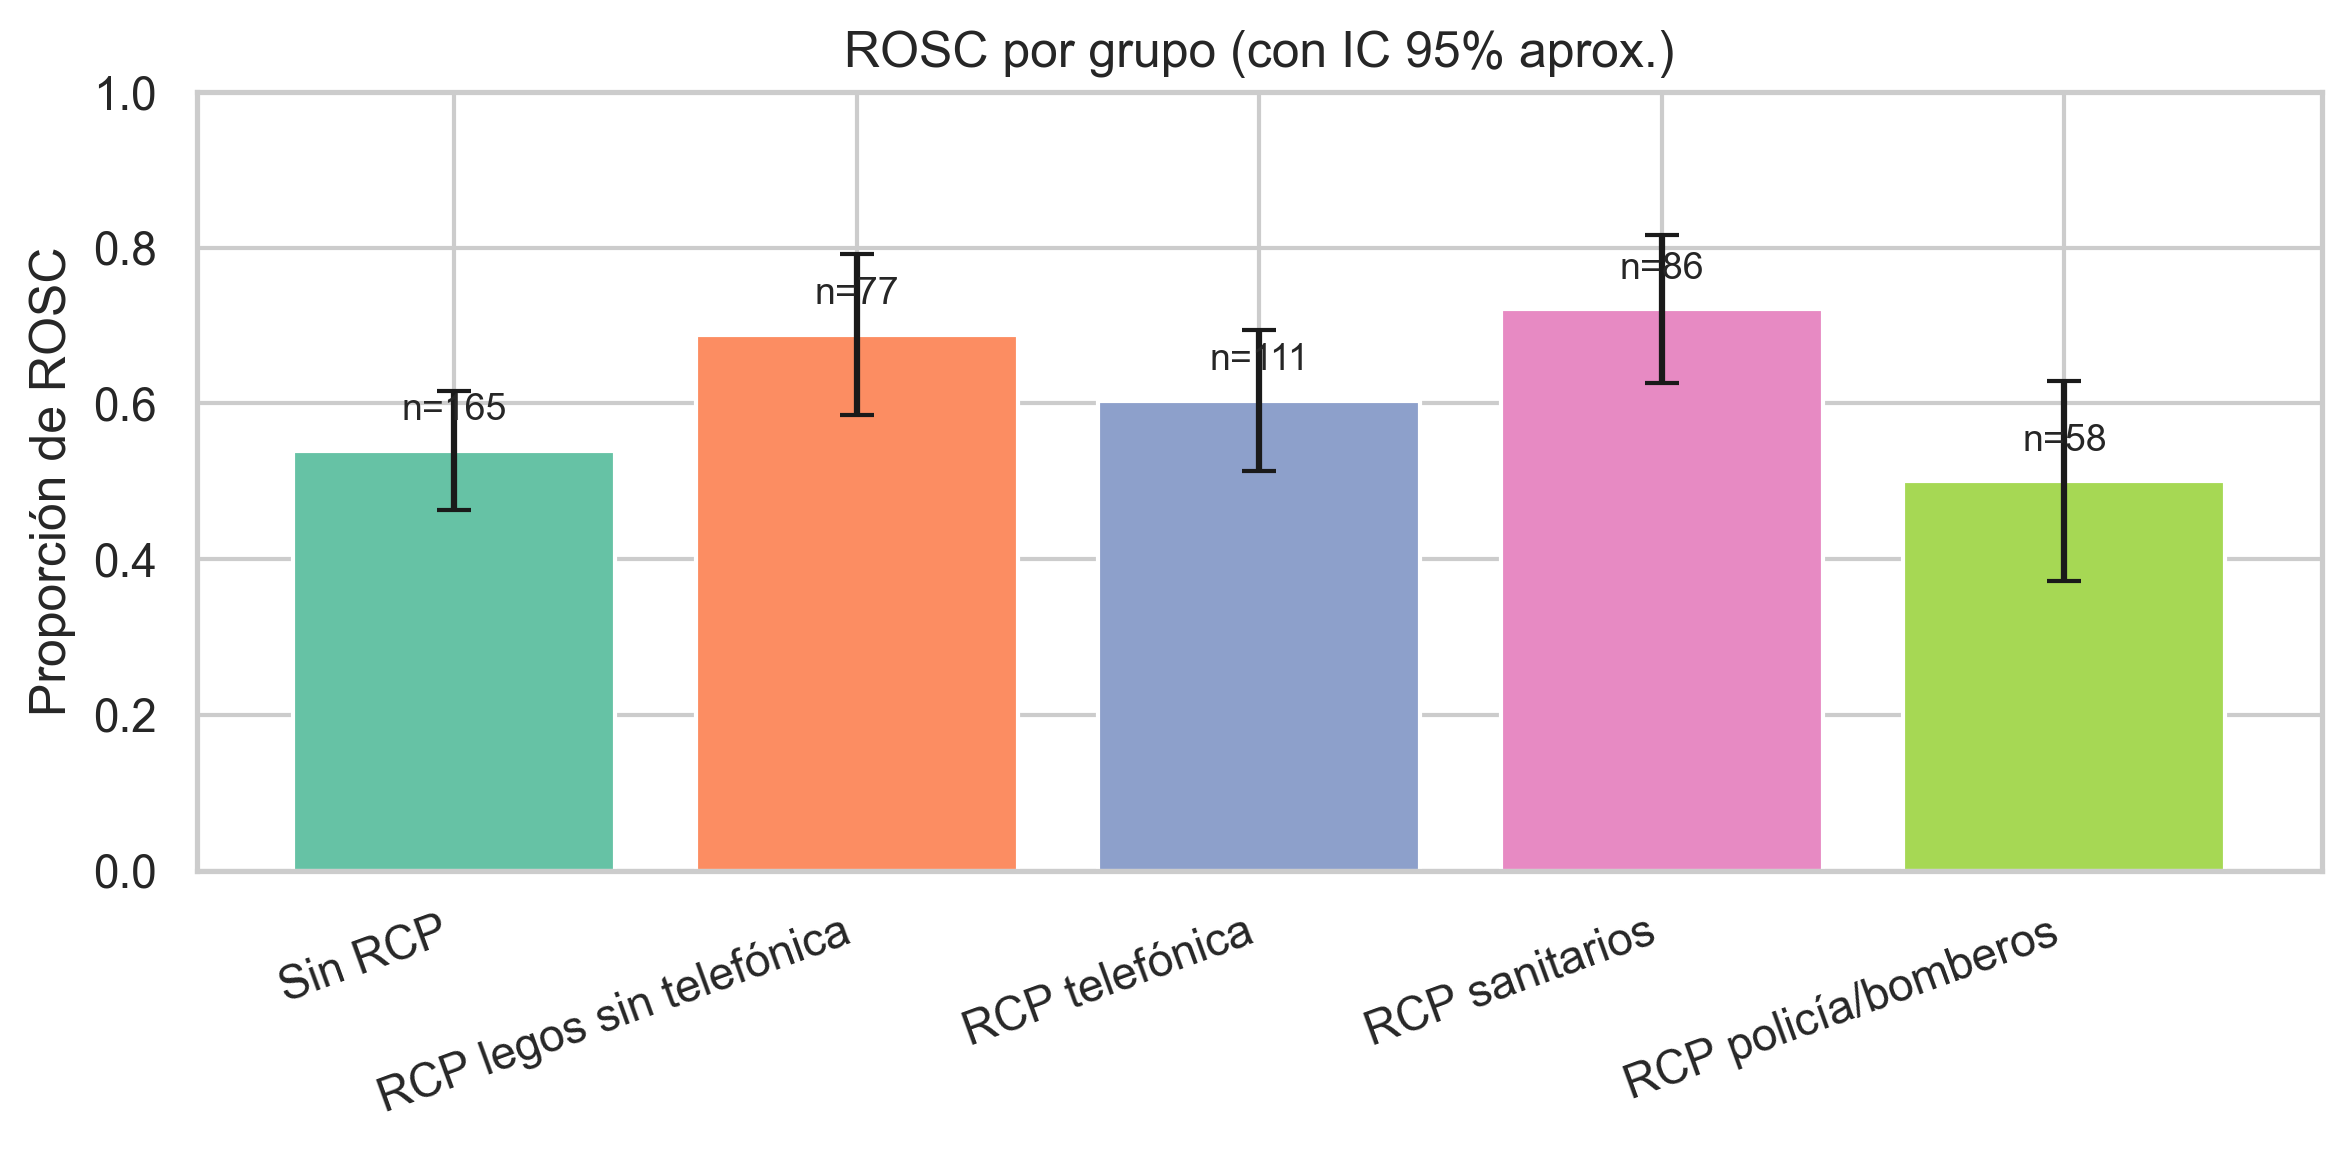

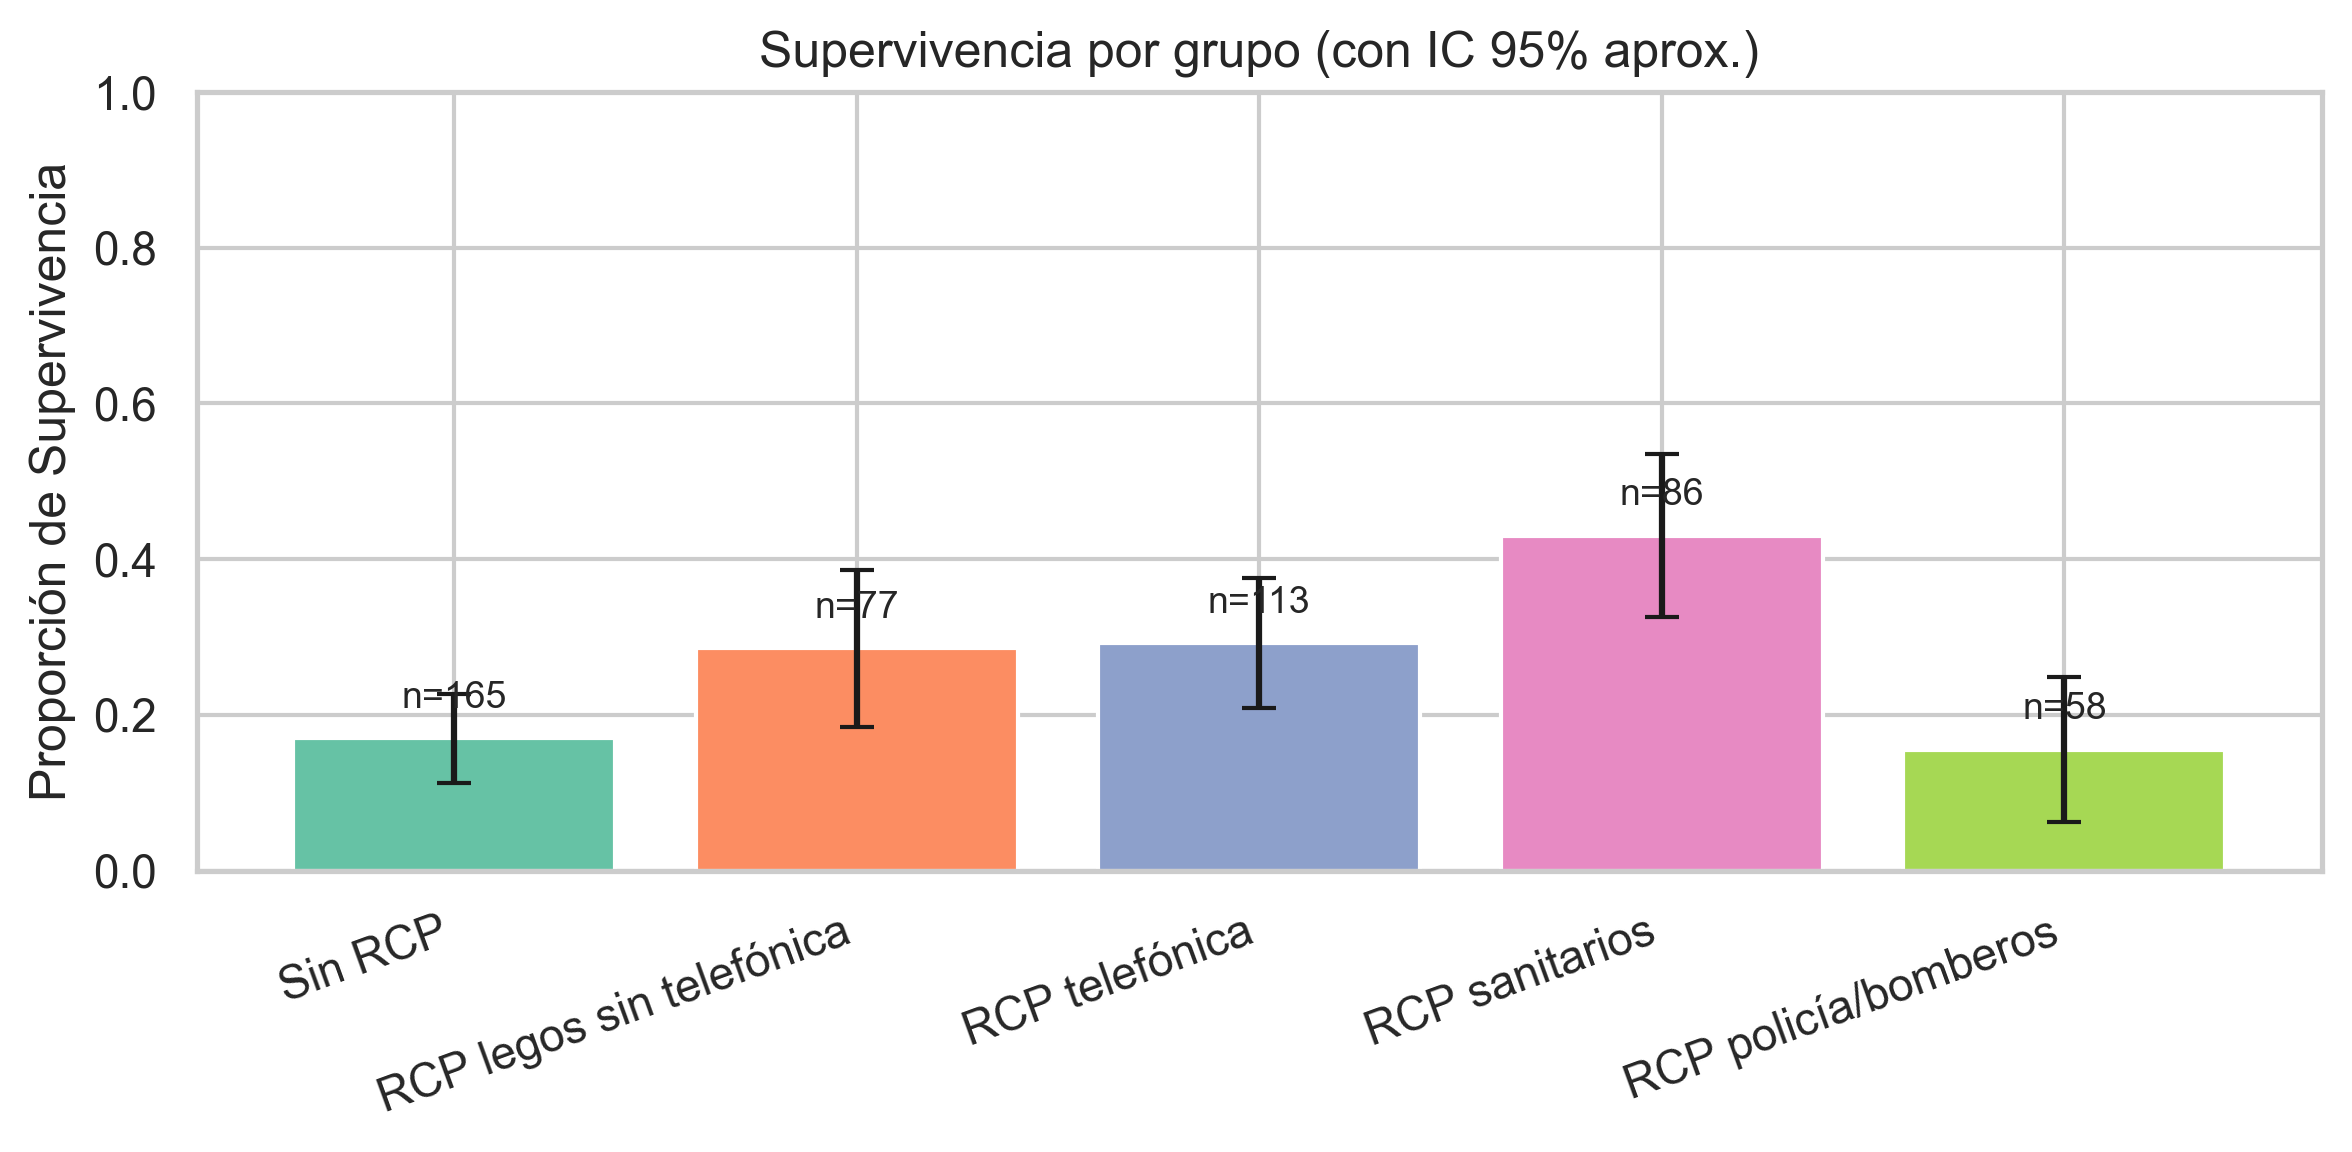

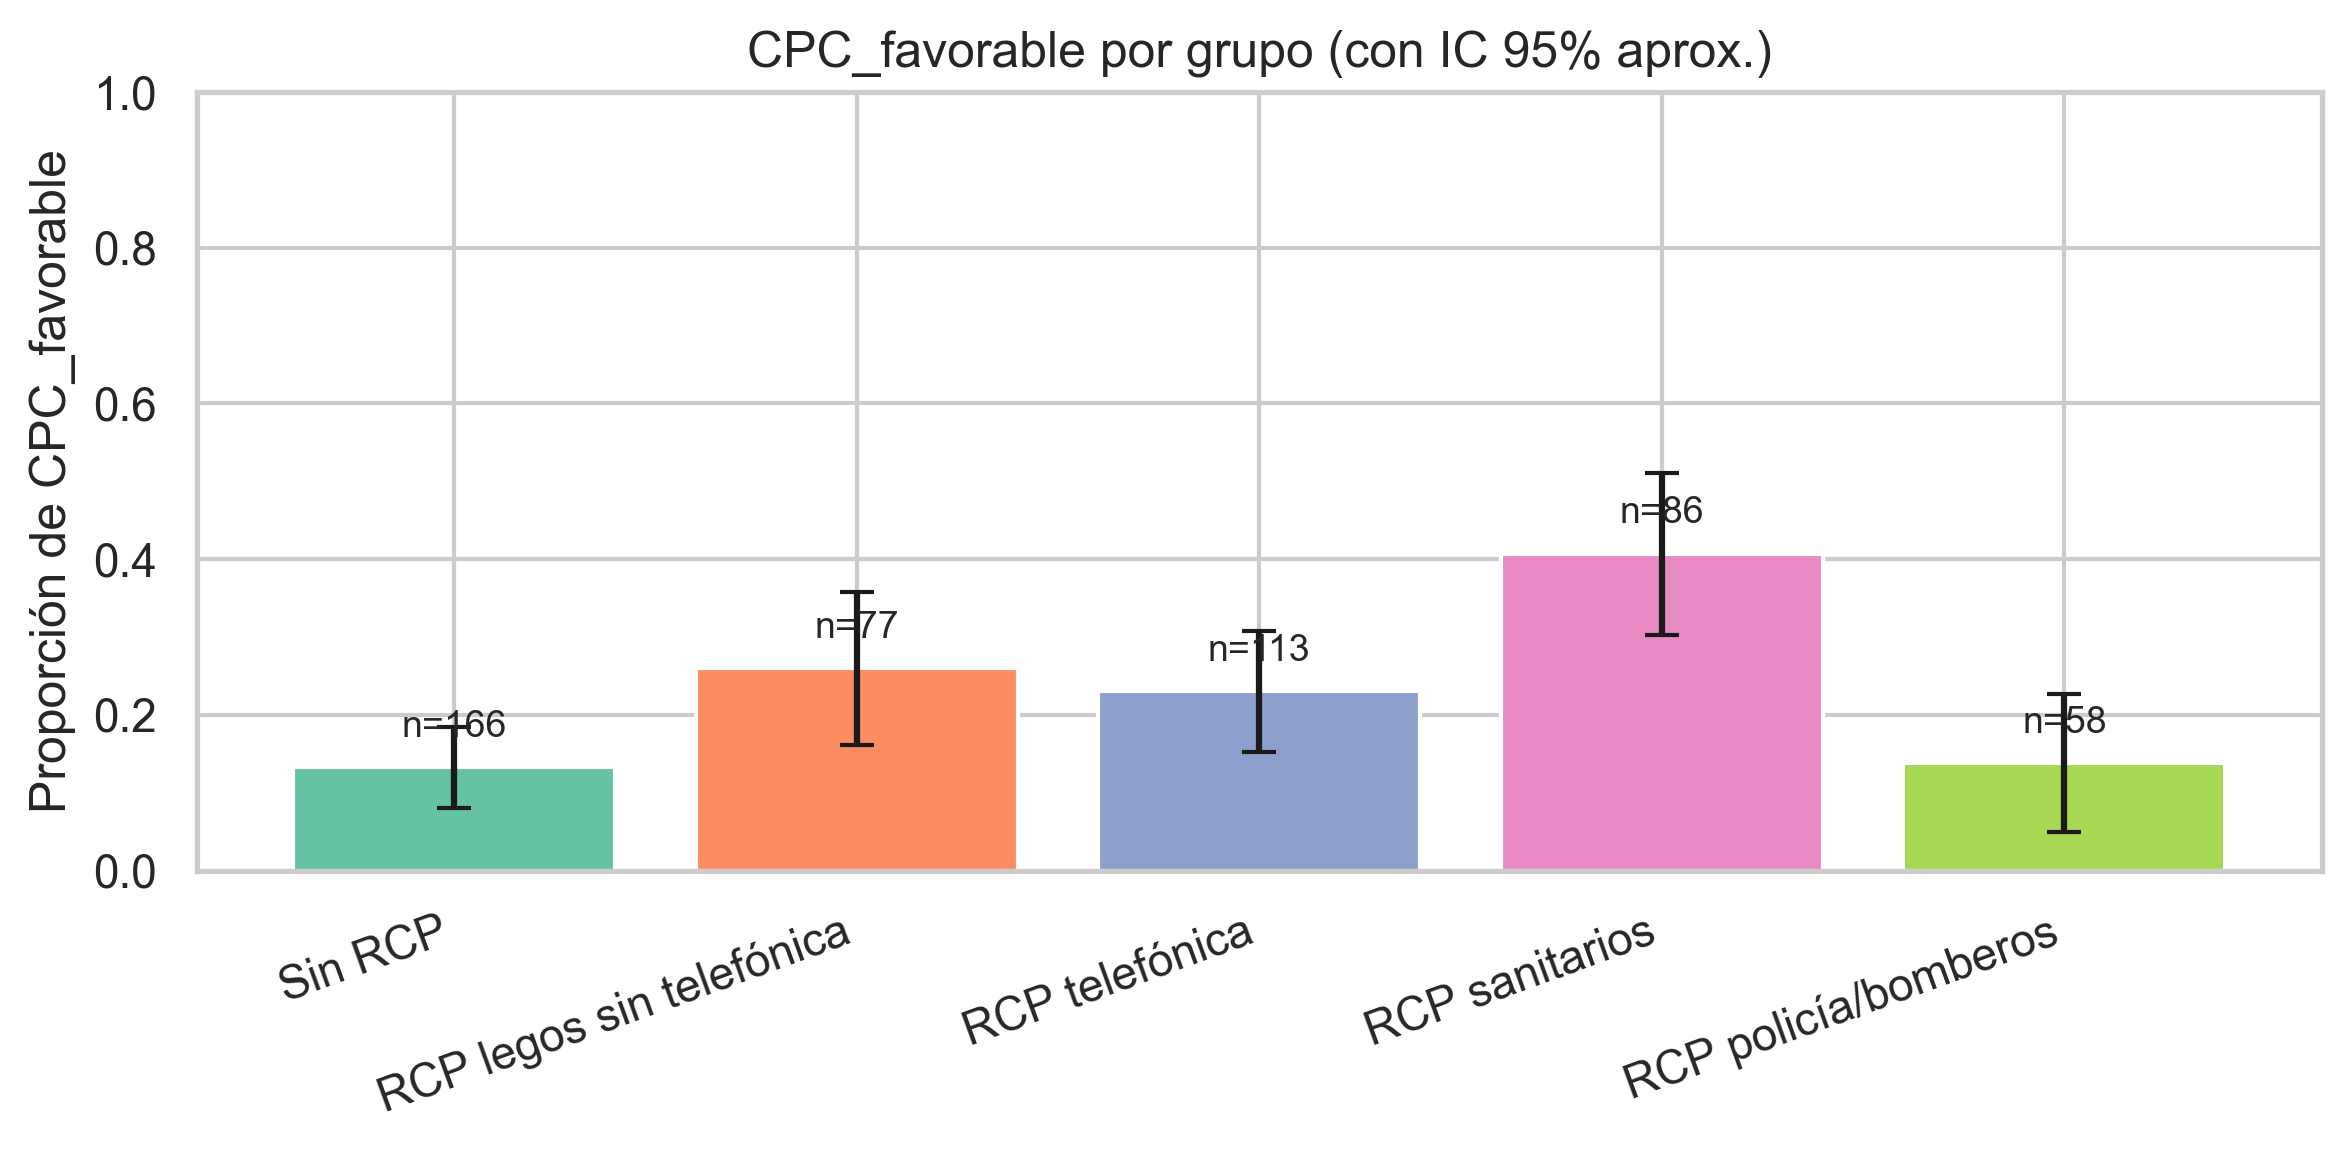

In [12]:
# Gráfica 2: Barras con IC de proporciones por grupo para cada outcome

def proporciones_ci(df_in, group_col, outcome_col):
    sub = df_in[[group_col, outcome_col]].dropna().copy()
    sub[outcome_col] = sub[outcome_col].astype(int)
    grp = sub.groupby(group_col)[outcome_col]
    n = grp.count()
    p = grp.mean()
    # IC 95% aproximado (normal) p ± 1.96*sqrt(p*(1-p)/n)
    se = np.sqrt((p*(1-p))/n)
    lcl = p - 1.96*se
    ucl = p + 1.96*se
    return pd.DataFrame({'n': n, 'p': p, 'LCL95': lcl.clip(0,1), 'UCL95': ucl.clip(0,1)})

for nombre, col in outcomes.items():
    stats_grp = proporciones_ci(df[df['grupo_rcp'].isin(['Sin RCP','RCP legos sin telefónica','RCP telefónica','RCP sanitarios','RCP policía/bomberos'])], 'grupo_rcp', col)
    stats_grp = stats_grp.loc[[g for g in ['Sin RCP','RCP legos sin telefónica','RCP telefónica','RCP sanitarios','RCP policía/bomberos'] if g in stats_grp.index]]
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(stats_grp))
    ax.bar(x, stats_grp['p'].values, yerr=[stats_grp['p'].values - stats_grp['LCL95'].values, stats_grp['UCL95'].values - stats_grp['p'].values], capsize=4, color=sns.color_palette('Set2', n_colors=len(stats_grp)))
    ax.set_xticks(x)
    ax.set_xticklabels(stats_grp.index, rotation=20, ha='right')
    ax.set_ylim(0, 1)
    ax.set_ylabel(f"Proporción de {nombre}")
    ax.set_title(f"{nombre} por grupo (con IC 95% aprox.)")
    for i, (n_i, p_i) in enumerate(zip(stats_grp['n'].values, stats_grp['p'].values)):
        ax.text(i, p_i + 0.03, f"n={n_i}", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"barras_{col}_por_grupo.png", dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

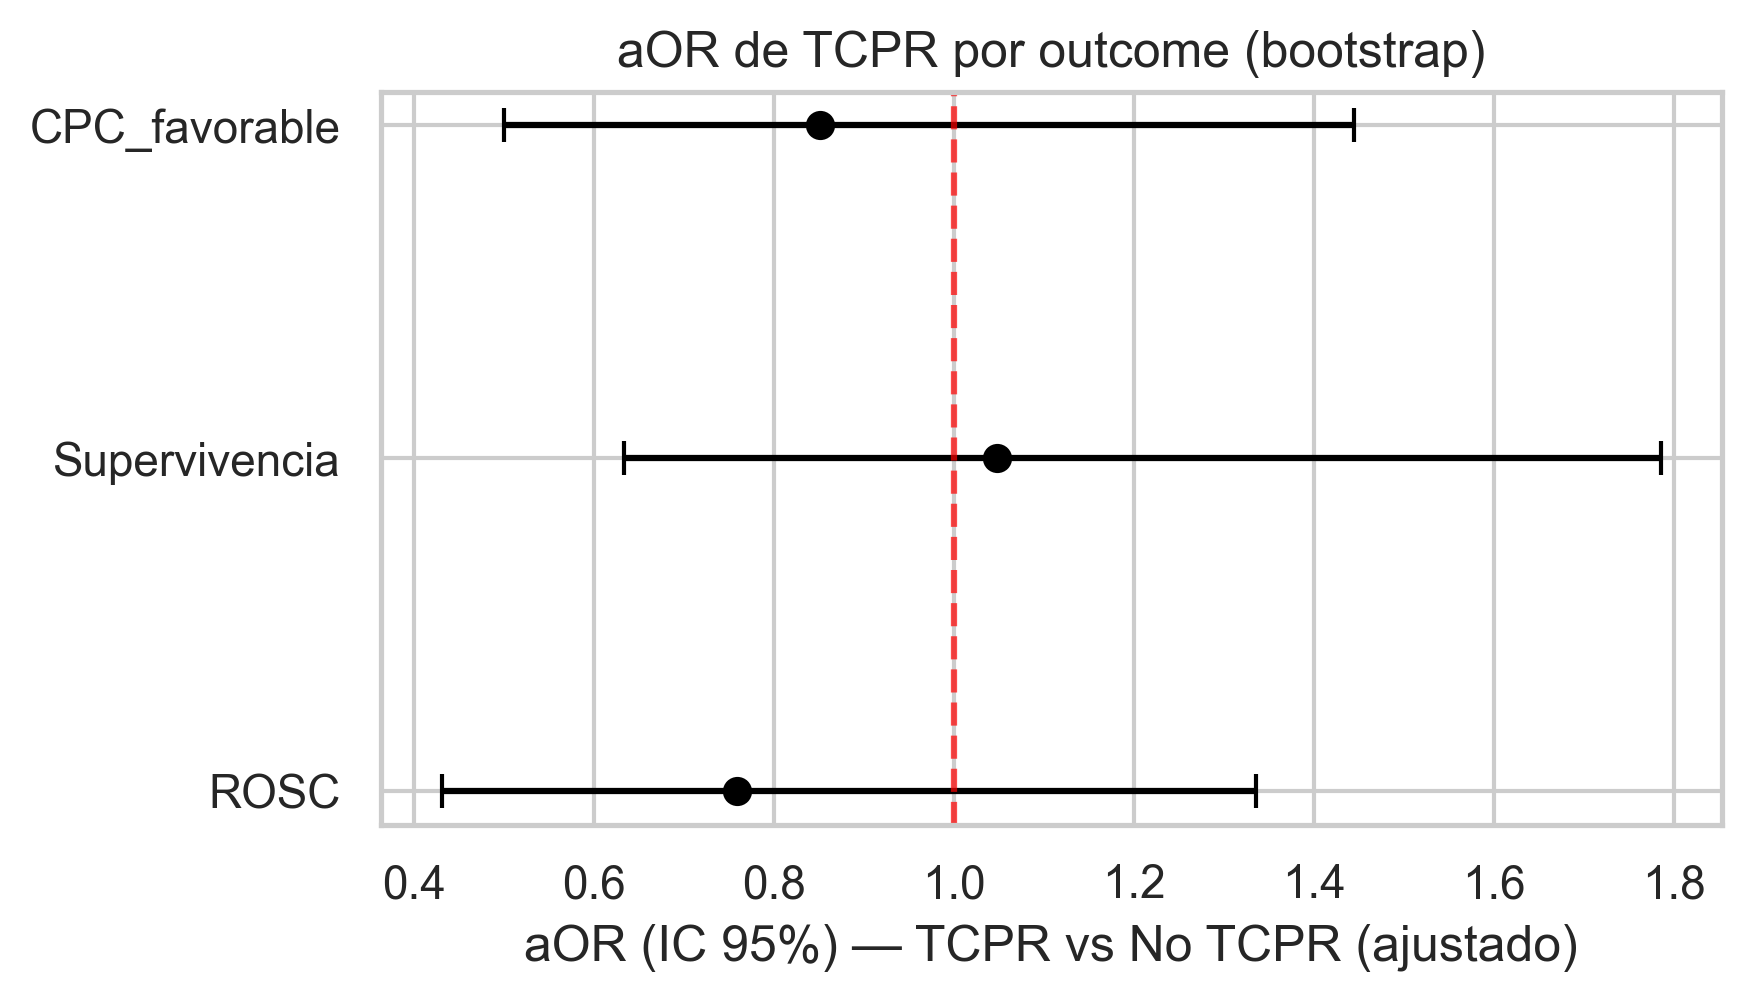

In [13]:
# Gráfica 3: Forest de aOR (TCPR) por outcome del modelo con bootstrap (si existe en memoria, si no se carga del CSV)

import pandas as pd

try:
    _ = ajustados_boot
except NameError:
    # Cargar desde JSON si no está en memoria
    import json
    with open(OUT_DIR / 'logistica_ajustada_bootstrap_tcp_vs_notcp.json', 'r') as f:
        ajustados_boot = json.load(f)

def plot_aor_tcp(outcomes_map, ajustados_boot):
    rows = []
    for nombre, col in outcomes_map.items():
        res = ajustados_boot.get(nombre, {})
        if not res:
            continue
        terms = res['resultados']
        # buscar TCPR
        term_tcp = next((t for t in terms if t['term'] == 'TCPR'), None)
        if term_tcp is None:
            continue
        rows.append({'Outcome': nombre, 'aOR': term_tcp['aOR'], 'LCL95': term_tcp['LCL95'], 'UCL95': term_tcp['UCL95']})
    if not rows:
        print('No hay resultados de aOR para TCPR')
        return
    dfp = pd.DataFrame(rows).set_index('Outcome').loc[['ROSC','Supervivencia','CPC_favorable']]
    labels = dfp.index.tolist()
    ors = dfp['aOR'].values
    lcl = dfp['LCL95'].values
    ucl = dfp['UCL95'].values
    y = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.errorbar(ors, y, xerr=[ors-lcl, ucl-ors], fmt='o', color='black', capsize=4)
    ax.axvline(1.0, color='red', linestyle='--', alpha=0.7)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlabel('aOR (IC 95%) — TCPR vs No TCPR (ajustado)')
    ax.set_title('aOR de TCPR por outcome (bootstrap)')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'forest_aOR_TCPR_outcomes.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

plot_aor_tcp(outcomes, ajustados_boot)

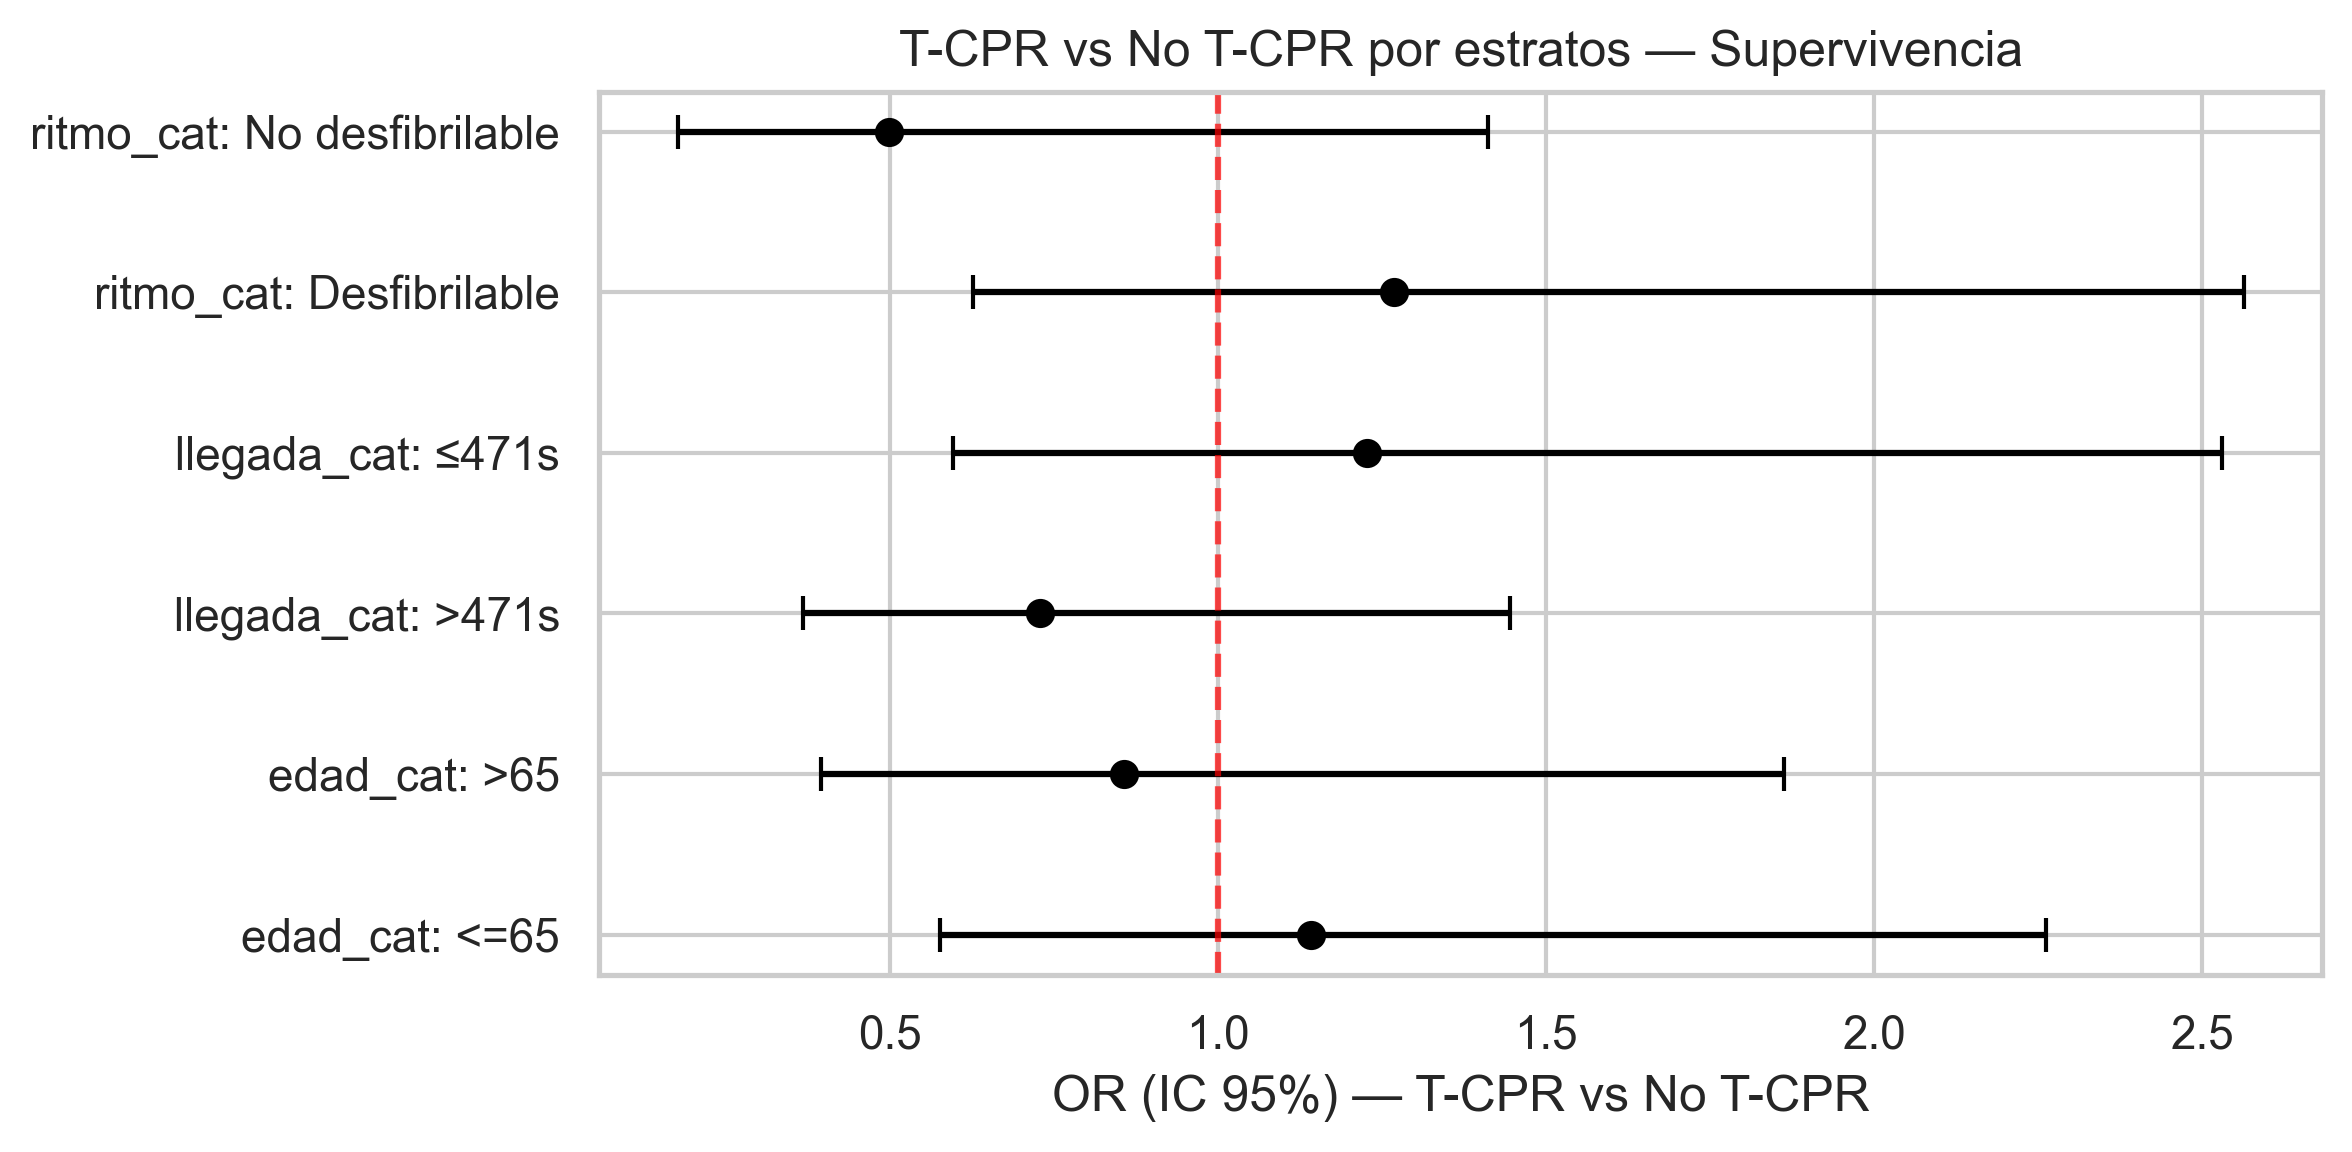

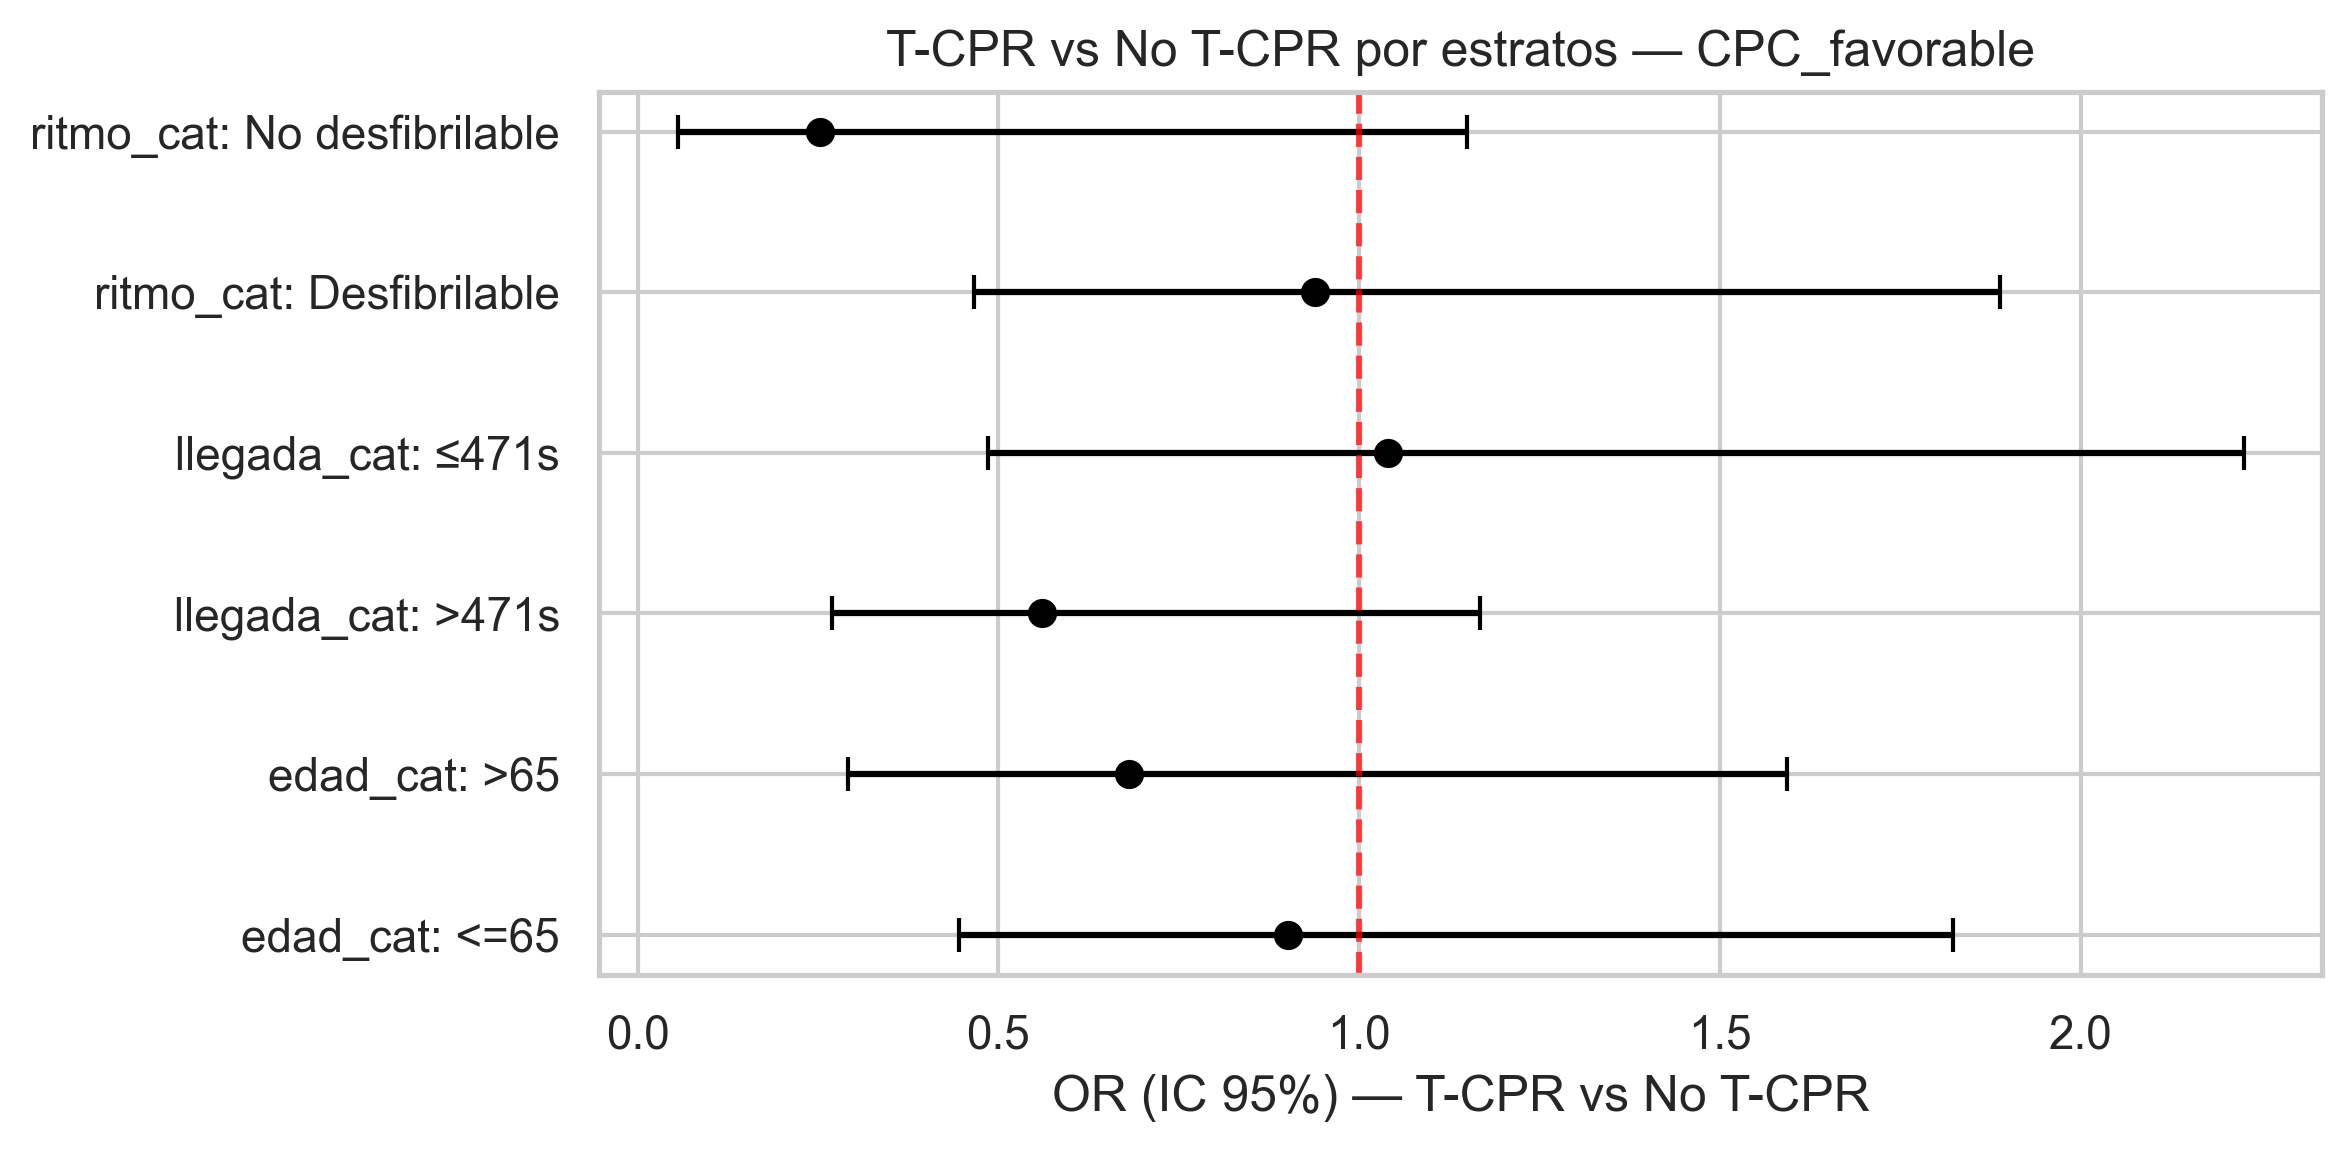

In [14]:
# Gráfica 4: Forest de TCPR vs NoTCPR por estratos (edad, llegada, ritmo) — outcome: Supervivencia y CPC favorable

import json
with open(OUT_DIR / 'estratos_tcp_vs_notcp.json', 'r') as f:
    estratos_plot = json.load(f)

for outcome in ['Supervivencia','CPC_favorable']:
    rows = []
    for estrato_col, niveles in estratos_plot.items():
        for lvl, res_map in niveles.items():
            if outcome in res_map:
                r = res_map[outcome]
                rows.append({'Estrato': f"{estrato_col}: {lvl}", 'OR': r['OR_TCPR_vs_NoT'], 'LCL95': r['LCL95'], 'UCL95': r['UCL95']})
    if not rows:
        continue
    dfp = pd.DataFrame(rows)
    dfp = dfp.sort_values('Estrato')
    y = np.arange(len(dfp))
    fig, ax = plt.subplots(figsize=(8, 0.5*len(dfp)+1))
    ax.errorbar(dfp['OR'], y, xerr=[dfp['OR']-dfp['LCL95'], dfp['UCL95']-dfp['OR']], fmt='o', color='black', capsize=4)
    ax.axvline(1.0, color='red', linestyle='--', alpha=0.7)
    ax.set_yticks(y)
    ax.set_yticklabels(dfp['Estrato'])
    ax.set_xlabel('OR (IC 95%) — T-CPR vs No T-CPR')
    ax.set_title(f'T-CPR vs No T-CPR por estratos — {outcome}')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"forest_TCPR_vs_NoTCPR_{outcome}_estratos.png", dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()